In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import ghalton
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import clean,to_radian,hann,res_to_rad
from Bessel_Interp import generate_halton_points
from rotation_2d import rot_cost_func, imrotate
from visualize import plot_cost_func, plot_cost_func_t, plot_volume
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
sept23_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_10.p','rb'))
sept23_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_8.p','rb'))
sept23_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_6_4.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()
#pickle.dump(axes_dict,open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/axes_dict.p','wb'))

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


(0.0, 0) xz xy 0_5_to_2_5


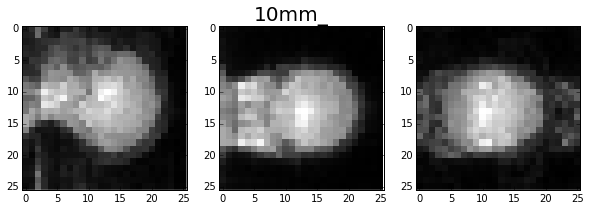

(0.0, 0) xz xy 3_0_to_5_0


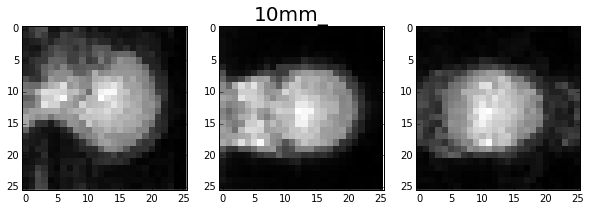

(0.5, 0) xz xy 0_5_to_2_5


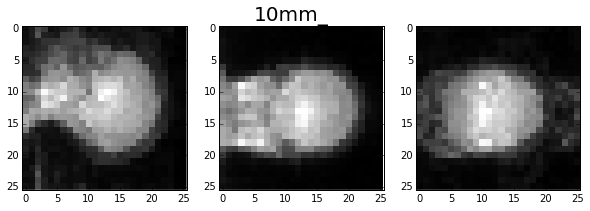

(3.0, 0) xz xy 3_0_to_5_0


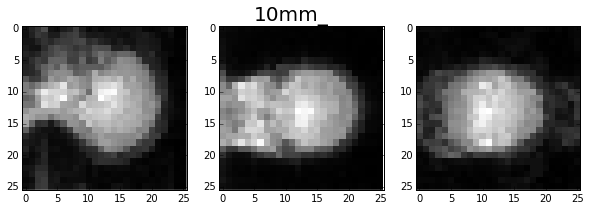

(1.0, 0) xz xy 0_5_to_2_5


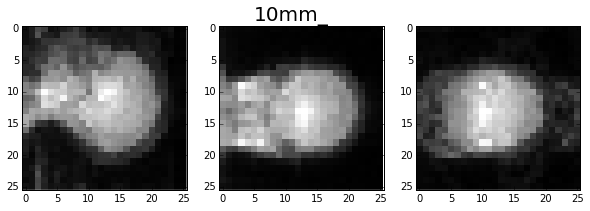

(3.5, 0) xz xy 3_0_to_5_0


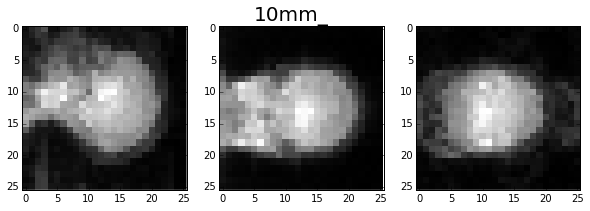

(1.5, 0) xz xy 0_5_to_2_5


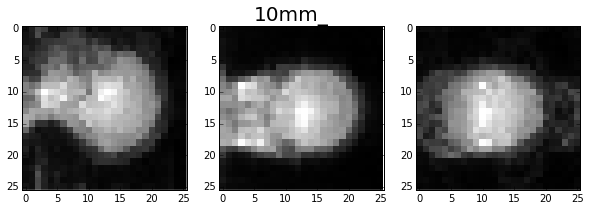

(4.0, 0) xz xy 3_0_to_5_0


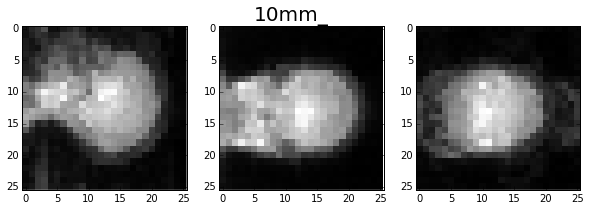

(2.0, 0) xz xy 0_5_to_2_5


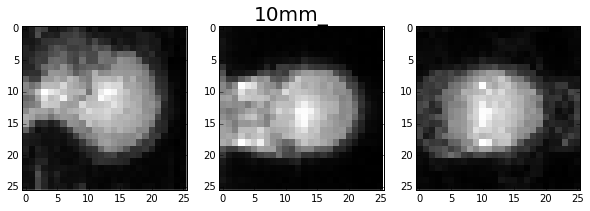

(4.5, 0) xz xy 3_0_to_5_0


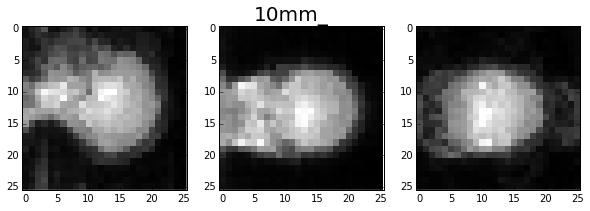

(2.5, 0) xz xy 0_5_to_2_5


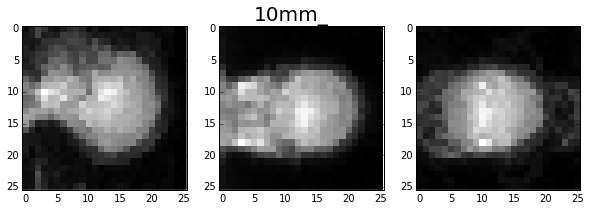

(5.0, 0) xz xy 3_0_to_5_0


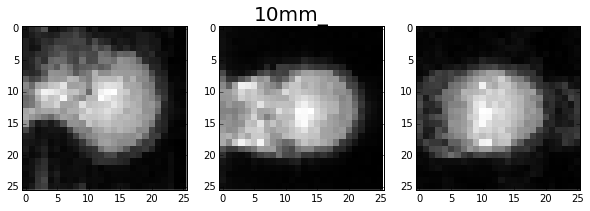

(0.0, 1) xz xy 0_5_to_2_5


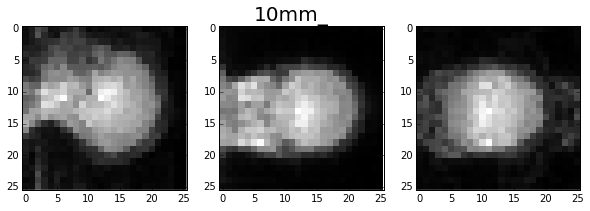

(0.0, 1) xz xy 3_0_to_5_0


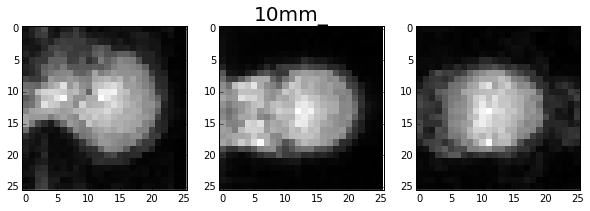

In [244]:
# 10mm
count = 0
ranges = ['0_5_to_2_5','3_0_to_5_0']
for rot_ax, trans_ax in axes_dict.iteritems():
    for rep in xrange(36):
        for rot_range in ranges:
            count += 1
            if count >= 15: break
            rot_angle = rep_to_angle(rep,rot_range)
            print str(rot_angle),rot_ax,trans_ax,rot_range
            plot_volume(sept23_dict_10[rot_ax][trans_ax][rot_range][str(rot_angle)],'10mm')

(0.0, 0) xz xy 0_5_to_2_5


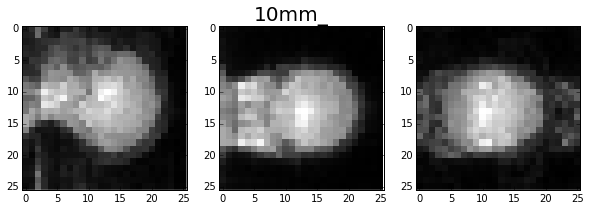

(0.0, 0) xz xy 3_0_to_5_0


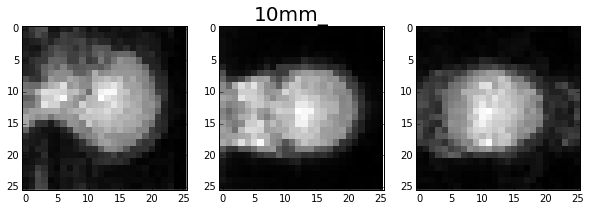

(0.5, 0) xz xy 0_5_to_2_5


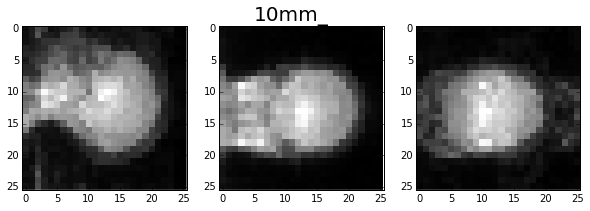

(3.0, 0) xz xy 3_0_to_5_0


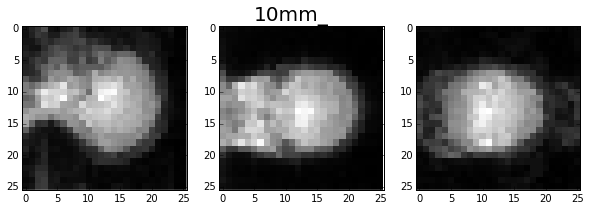

(1.0, 0) xz xy 0_5_to_2_5


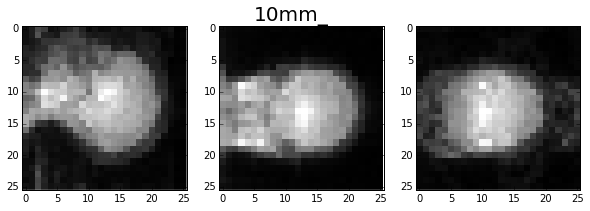

(3.5, 0) xz xy 3_0_to_5_0


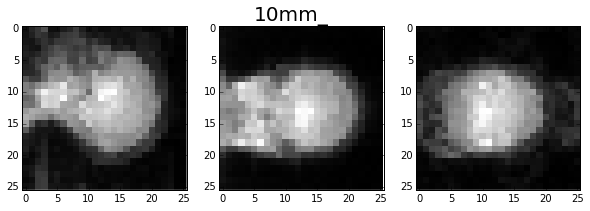

(1.5, 0) xz xy 0_5_to_2_5


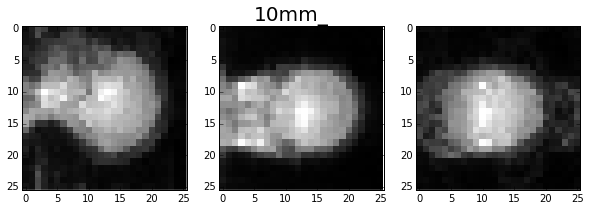

(4.0, 0) xz xy 3_0_to_5_0


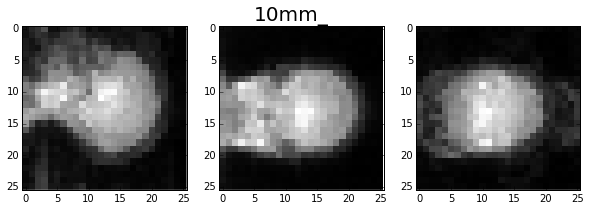

(2.0, 0) xz xy 0_5_to_2_5


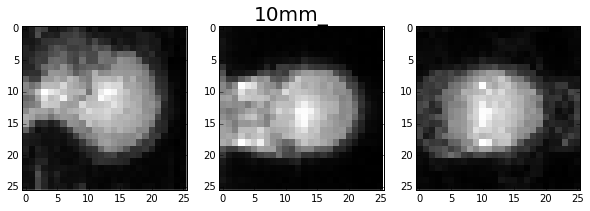

(4.5, 0) xz xy 3_0_to_5_0


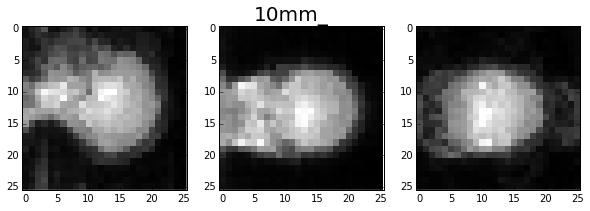

(2.5, 0) xz xy 0_5_to_2_5


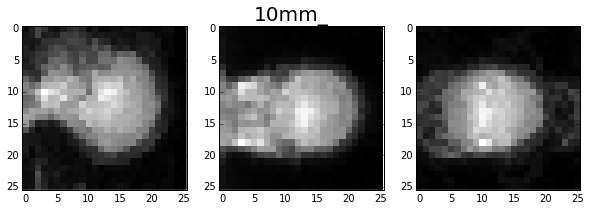

(5.0, 0) xz xy 3_0_to_5_0


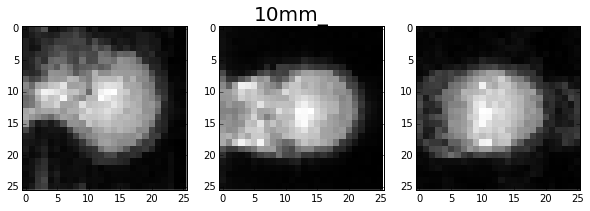

(0.0, 1) xz xy 0_5_to_2_5


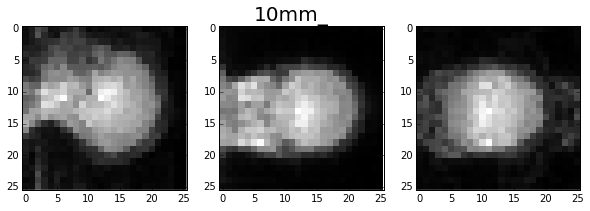

(0.0, 1) xz xy 3_0_to_5_0


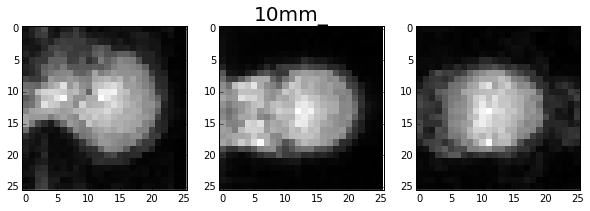

In [245]:
# 8mm
count = 0
ranges = ['0_5_to_2_5','3_0_to_5_0']
for rot_ax, trans_ax in axes_dict.iteritems():
    for rep in xrange(36):
        for rot_range in ranges:
            count += 1
            if count >= 15: break
            rot_angle = rep_to_angle(rep,rot_range)
            print str(rot_angle),rot_ax,trans_ax,rot_range
            plot_volume(sept23_dict_10[rot_ax][trans_ax][rot_range][str(rot_angle)],'10mm')

In [6]:
# function to help convert rotation axis to the unit vector of rotation
def ax_to_w(rot_ax):
    '''
    rot_ax: roation axis
    wx,wy,wz: corresponding vector of rotation for the code implementation
    '''
    if(rot_ax == 'x'): wx,wy,wz = 0,1,0
    elif(rot_ax == 'y'): wx,wy,wz = -1,0,0
    elif(rot_ax == 'z'): wx,wy,wz = 0,0,-1
    elif(rot_ax == 'xy'): wx,wy,wz = -1,1,0
    elif(rot_ax == 'xz'): wx,wy,wz = 0,1,-1
    else: wx,wy,wz = -1,0,-1
    return wx,wy,wz

In [7]:
def rep_to_angle(rep, rot_range):
    counter = rep % 6
    rotation_angle = 0.0
    translation_step = rep / 6 

    if rot_range == '0_5_to_2_5':
        if(counter != 0):
            rotation_angle = 0.5 * counter
    else: 
        # range = 3.0 to 5.0
        if(counter != 0):
            rotation_angle = 3.0 + (0.5 * (counter - 1))
    return rotation_angle, translation_step

###  Axis-Angle Rotation

If v is a vector in $R^3$ and $\boldsymbol{\omega}$ is a unit vector describing an axis of rotation about which $\mathbf{v}$ is rotated by an angle $\theta$ the Rodrigues' rotation formula to obtain the rotated vector is

$$\mathbf{v}_\mathrm{rot} = (\cos\theta) \mathbf{v}  + (\sin\theta) (\boldsymbol{\omega} \times \mathbf{v})
  +  (1 - \cos\theta) (\boldsymbol{\omega} \cdot \mathbf{v}) \boldsymbol{\omega}~$$

In [8]:
from rotation_3d import rot_cost_func_3d,volrotate

Make sure the through plane rotations are correct

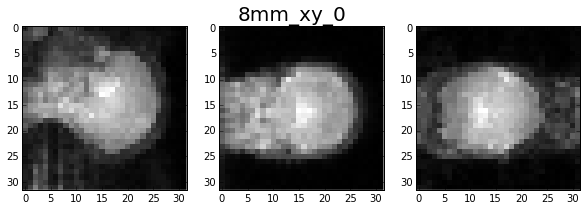

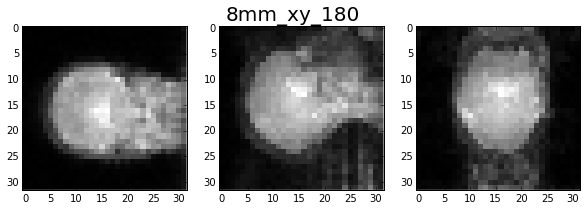

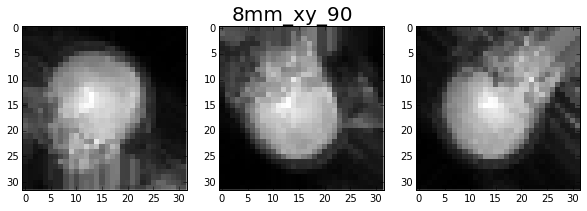

In [10]:
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','xy_0')
plot_volume(volrotate(testVol1,180,1,1,0),'8mm','xy_180')
plot_volume(volrotate(testVol1,90,1,1,0),'8mm','xy_90')

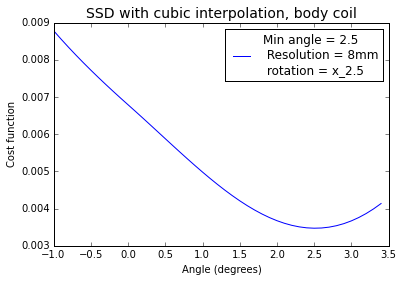

In [11]:
# Test tricubic interpolation on 8mm, x-axis rotation 
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(-1.0,3.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_2.5'%rot_ax, 'body')

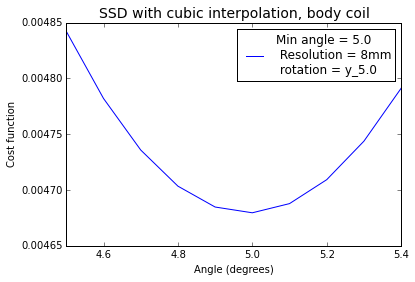

In [24]:
# Test tricubic interpolation on 8mm, y-axis rotation 
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(4.5,5.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

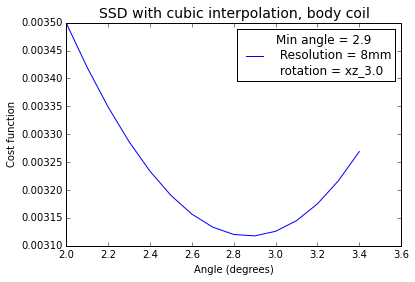

In [25]:
# Test tricubic interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(3.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(2.0,3.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_3.0'%rot_ax, 'body')

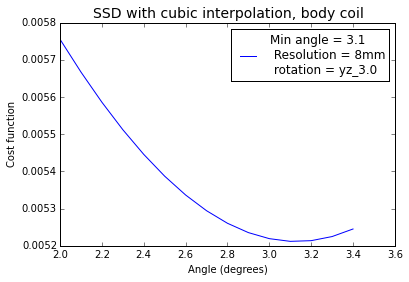

In [27]:
# Test tricubic interpolation on 10mm, yz-axis rotation 
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(3.0, 0)]
res = '8mm'
rad = res_to_rad(res)
thetas = np.arange(2.0,3.5,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_3.0'%rot_ax, 'body')

16
-1 1 0


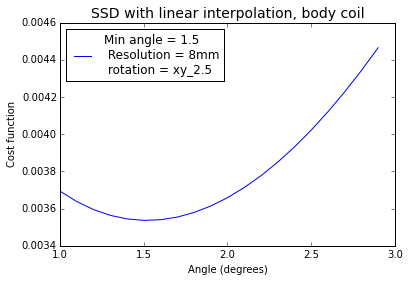

In [28]:
# Test trilinear interpolation on 8mm, xy-axis rotation 
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(1.0,3.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_2.5'%rot_ax, 'body')

16
-1 1 0


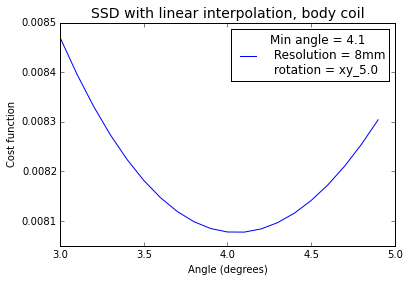

In [29]:
# Test trilinear interpolation on 8mm, xy-axis rotation 
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(3.0,5.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')

16
-1 0 -1


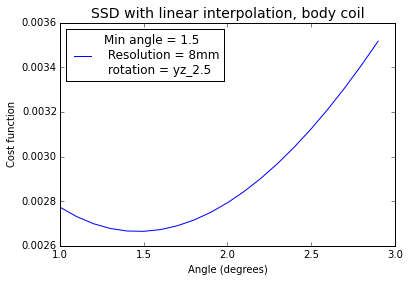

In [30]:
# Test trilinear interpolation on 8mm, yz-axis rotation 
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(1.0,3.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_2.5'%rot_ax, 'body')

16
-1 0 -1


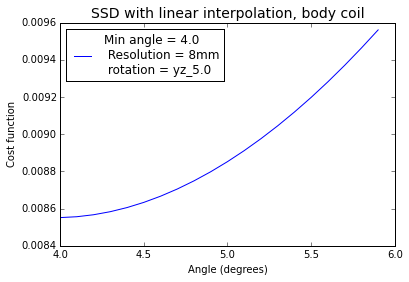

In [31]:
# Test trilinear interpolation on 8mm, yz-axis rotation 
rot_ax = 'yz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(4.0,6.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')

16
0 1 -1


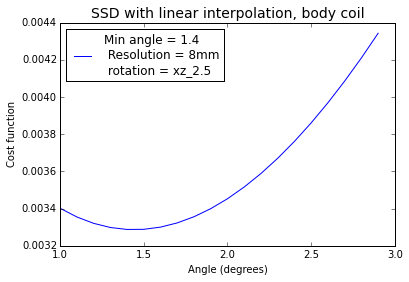

In [32]:
# Test trilinear interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(1.0,3.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_2.5'%rot_ax, 'body')

16
0 1 -1


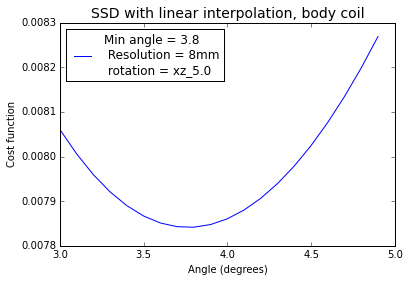

In [33]:
# Test trilinear interpolation on 8mm, xz-axis rotation 
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
res = '8mm'
rad = res_to_rad(res)
print rad
thetas = np.arange(3.0,5.0,0.1)
wx,wy,wz = ax_to_w(rot_ax)
print wx,wy,wz
cost = rot_cost_func_3d(sphere_mask(testVol1,rad), sphere_mask(testVol2,rad), thetas, wx,wy,wz,interpolation = 'trilinear')
plot_cost_func(thetas,cost,res,'linear','%s_5.0'%rot_ax, 'body')

### Test Multiprocess on cubic rotations

In [249]:
dict_ = sept23_dict_10.copy()
def cubic_rotations(rot_ax):
    cost_dict = {}
    rad = res_to_rad(res)
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    
    if(rot_ax == 'x'): ax = 0
    elif(rot_ax == 'y'): ax = 1
    else: ax = 2
        
    for rot_range in ranges:
        for loop in xrange(6):
            ref = rep_to_angle(loop * 6,rot_range)
            for i in xrange(1,6):
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                deg = rot_angle[0]
                thetas = np.arange(-deg-3,deg+3,0.1)
                cost_dict[rot_angle] = rot_cost_func(sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(ref)],rad),
                                                    sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(rot_angle)],rad),
                                                    thetas,axis=ax, interpolation='bicubic')
    return cost_dict

In [233]:
if __name__ == '__main__':
    keys =  axes_dict.keys()
    nproc = len(keys)
    pool = multiprocessing.Pool(processes = nproc)
    cost_dict = pool.map(cubic_rotations, keys)
    filename = '/Users/zyzdiana/Desktop/sept23_cubic_%s_rotation.p' % (rot_ax)
    pickle.dump(cost_dict,open(filename,'wb'))

In [201]:
def plot_results(cost_dict, res, interpolation):
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    for idx, rot_ax in enumerate(['x', 'y', 'z']):
        for rot_range in ranges:
            for loop in xrange(6):
                for i in xrange(1,6):
                    rep = i + loop * 6
                    rot_angle = rep_to_angle(rep,rot_range)
                    deg = rot_angle[0]
                    if interpolation == 'cubic':
                        thetas = np.arange(-deg-2,deg+2,0.01)
                    else:
                        thetas = np.arange(-deg-3,deg+3,0.01)
                    rot = '%s_%s' % (str(rot_angle[0]),rot_ax)
                    plot_cost_func(thetas,cost_dict[idx][rot_angle],res,interpolation,rot)
                    plt.show() 

In [202]:
def get_min(cost_dict, res, rot='iso'):
    # Gets the minimum search angle for all 
    min_ls = []
    axes = ['axis0','axis1','axis2']
    degrees = np.arange(0.5, 5.5, 0.5)
    for i, ax in enumerate(axes):
        for deg in degrees:
            thetas = np.arange(-deg-3,deg+3,0.01)
            for idx, coil in enumerate(['head', 'body']):
                cost = cost_dict[i][deg][coil]
                min_ls.append([deg,abs(thetas[np.argmin(cost,axis=0)]),idx])
    return np.array(min_ls)

def scatter_plot(cost_dict, res, interpolation = 'cubic'):
    colors = ['red','blue','green']
    ranges = ['0_5_to_2_5','3_0_to_5_0']
    count = 0
    for idx, rot_ax in enumerate(['x', 'y', 'z']):
        count = 1
        for rot_range in ranges:
            for loop in xrange(6):
                for i in xrange(1,6):
                    rep = i + loop * 6
                    if(count == 1): 
                        label = rot_ax
                        count = 0
                    else: label = None
                    rot_angle = rep_to_angle(rep,rot_range)
                    deg = rot_angle[0]
                    if interpolation == 'cubic':
                        thetas = np.arange(-deg-2,deg+2,0.01)
                    else:
                        thetas = np.arange(-deg-3,deg+3,0.01)
                    cost = cost_dict[idx][rot_angle]
                    y = abs(thetas[np.argmin(cost,axis=0)])
                    plt.scatter(deg, y, s = 80, c = colors[idx],alpha = 0.6,marker='x',label = label)
    plt.plot([0,6],[0,6],c='black')
    plt.xlim([0,6])
    plt.ylim([0,6])
    plt.legend(loc=4)
    plt.title('Search Results for %s Resolution' %res)
    #plt.show()

### Test Multiprocess on trilinear rotations

In [13]:
dict_ = sept23_dict_10.copy()
res = '10'
def linear_rotations(rot_ax):
    cost_dict = {}
    rad = res_to_rad(res)
    ranges = ['0_5_to_2_5','3_0_to_5_0']

    wx,wy,wz = ax_to_w(rot_ax)

    for rot_range in ranges:
        for loop in xrange(6):
            ref = rep_to_angle(loop * 6,rot_range)
            for i in xrange(1,6):
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                deg = rot_angle[0]
                thetas = np.arange(-deg-3,deg+3,0.01)
                cost_dict[rot_angle] = rot_cost_func_3d(sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(ref)],rad),
                                                        sphere_mask(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(rot_angle)],rad),
                                                        thetas, wx,wy,wz,interpolation='trilinear')
    return cost_dict

In [ ]:
keys =  ['xz']
nproc = len(keys)
pool = multiprocessing.Pool(processes = nproc)
print keys, len(keys)
cost_dict = pool.map(linear_rotations, keys)
filename = '/Users/zyzdiana/Desktop/sept23_linear_%s_rotation.p' % (res)
pickle.dump(cost_dict,open(filename,'wb'))

## Translations

In [9]:
from Bessel_Interp import generate_halton_points,circle_mask_points,bessel_rotate_arbitrary_points
from rotation_3d import trilinear_interp

In [10]:
import scipy.ndimage
def trans_cost_func_3d(vol1, vol2, trans, wx, wy, wz,order=1,mask = False):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    cost_func = np.zeros([len(trans),])
    for idx, t in enumerate(trans):
        new_vol2 = scipy.ndimage.interpolation.shift(vol2,np.array([wx,wy,wz])*t,order=order, mode='wrap')
        if mask:
            rad = vol1.shape[0]/2
            cost_func[idx] = cf_ssd(sphere_mask(new_vol2,rad),sphere_mask(vol1,rad))
        else:
            cost_func[idx] = cf_ssd(new_vol2,vol1)
    return cost_func

def halton_cost_func_t(N, vol1, vol2, t, wx, wy, wz):
    '''
    N: Number of Halton Sampling Points
    vol1: original image
    vol2: volume to be rotated
    theta: rotation by degrees
    t: list of translations to try
    '''
    cost_func = np.zeros(len(t))
    # generate Halton Sequence in the 32*32*32 grid
    pts = generate_halton_points(N * 2, 3, len(vol1) - 1)
    x1 = 31 * pts[:,0]
    y1 = 31 * pts[:,1]
    z1 = 31 * pts[:,2]
    for idx, th in enumerate(t):
        v2 = trilinear_interp(vol2, x1+wx*th, y1+wy*th, z1+wz*th)
        v1 = trilinear_interp(vol1, x1, y1, z1)
        cost_func[idx] = cf_ssd(v2,v1)
    return cost_func

In [11]:
def translations(res,rot_ax,order = 1,mask = False):
    if ('10' in res): dict_ = sept23_dict_10
    if ('8' in res): dict_ = sept23_dict_8
    if ('6_4' in res): dict_ = sept23_dict_6_4
    cost_dict = {}
    wx,wy,wz = ax_to_w(axes_dict[rot_ax])
    trans = np.arange(-3,3,0.1)
    for rot_range in ranges:
        for loop in xrange(1,6):
            for i in xrange(6):
                ref = rep_to_angle(i,rot_range)
                rep = i + loop * 6
                rot_angle = rep_to_angle(rep,rot_range)
                step = rot_angle[1]
                cost_dict[rot_angle] = trans_cost_func_3d(dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(ref)],
                                                          dict_[rot_ax][axes_dict[rot_ax]][rot_range][str(rot_angle)],
                                                          trans, wx, wy, wz,order)
    return cost_dict

In [ ]:
testVol1 = sept23_dict_10['z']['z'][ranges[0]]['(0.0, 0)']
testVol2 = sept23_dict_10['z']['z'][ranges[0]]['(0.0, 5)']
trans = np.arange(-1,1,0.01)
wx,wy,wz = ax_to_w('z')
for N in [100,300,500,1000,5000,10000,20000,50000]:
    cost_t = halton_cost_func_t(N, testVol1,testVol2, trans, wx,wy,wz)
    plot_cost_func_t(trans,cost_t,'10mm','z_5mm','N = %d body' %N)
    plt.show()

16


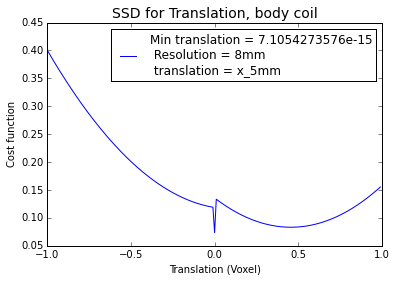

In [25]:
rot_ax = 'x'
testVol1 = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = sept23_dict_10[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 4)]
res = '8mm'
rad = res_to_rad(res)
print rad
trans = np.arange(-1,1,0.01)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
#wx,wy,wz = -1,1,0
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

16


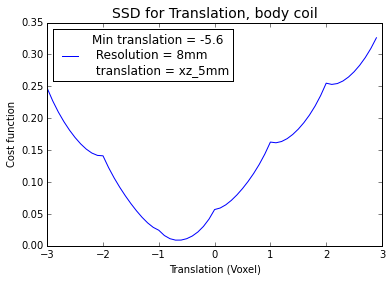

In [122]:
rot_ax = 'xz'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
res = '8mm'
rad = res_to_rad(res)
print rad
trans = np.arange(-3,3,0.1)
wx,wy,wz = ax_to_w(axes_dict[rot_ax])
#wx,wy,wz = -1,1,0
cost_t = trans_cost_func_3d(testVol1,testVol2, trans, wx,wy,wz,mask=True)
plot_cost_func_t(trans,cost_t,res,'%s_5mm'%rot_ax,'body')
plt.show()

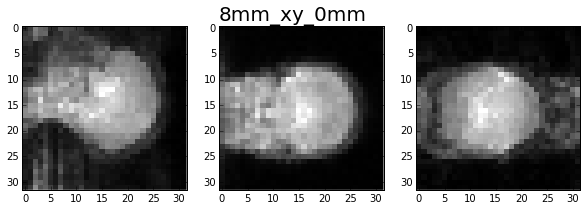

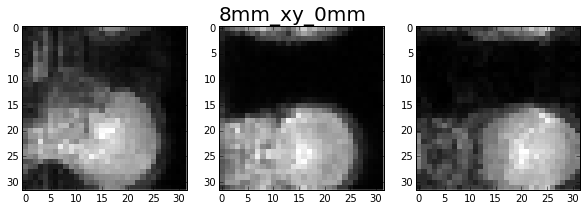

In [93]:
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','xy_0mm')
trans_testVol1 = scipy.ndimage.interpolation.shift(testVol1,[8,8,0],order=1,mode = 'wrap')
plot_volume(trans_testVol1,'8mm','xy_0mm')

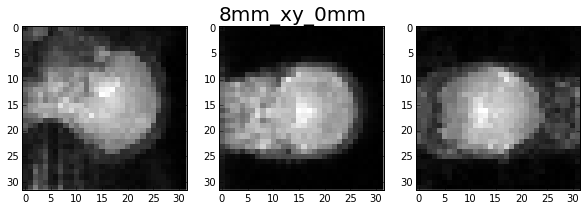

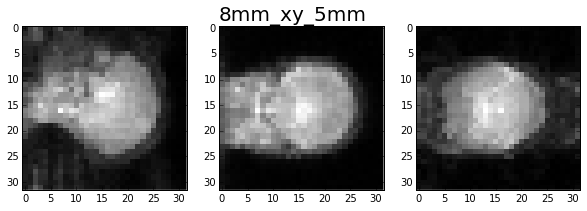

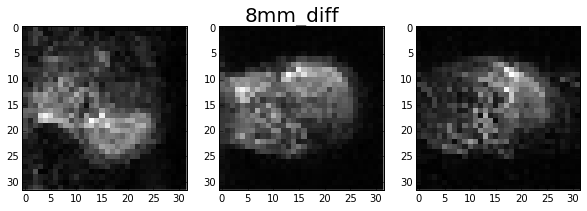

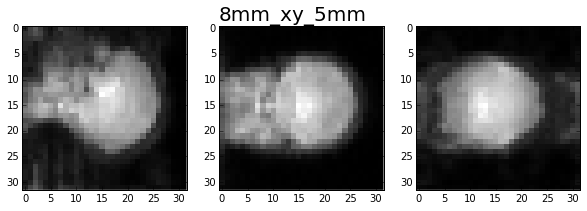

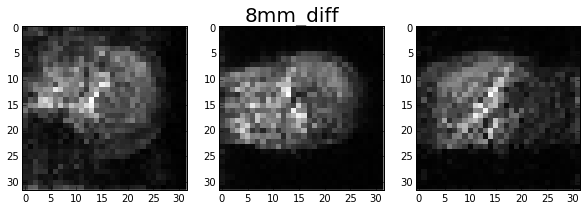

In [78]:
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
plot_volume(testVol1,'8mm','xy_0mm')
plot_volume(testVol2,'8mm','xy_5mm')
plot_volume(testVol2-testVol1,'8mm','diff')
step = 5./8.
trans_testVol2 = scipy.ndimage.interpolation.shift(testVol2,[-step,-step,0],order=1,mode = 'wrap')
plot_volume(trans_testVol2,'8mm','xy_5mm')
plot_volume(trans_testVol2-testVol2,'8mm','diff')
#plot_volume(volrotate(testVol1,180,1,1,0),'8mm','xy_180')
#plot_volume(volrotate(testVol1,90,1,1,0),'8mm','xy_90')

Test Halton Sampling on Translations

In [305]:
# Linear Translation with mask
cost_trans_linear_masked = {}
for k in axes_dict:
    print k,
    cost_trans_linear_masked[k] = translations('10mm',k,mask = True)
pickle.dump(cost_trans_linear_masked, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_10_masked.p','wb'))

xz y yz xy x z


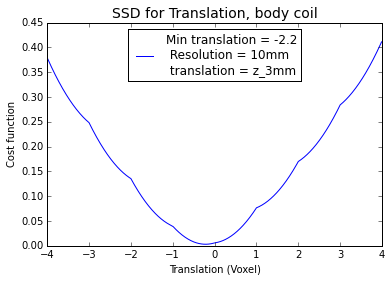

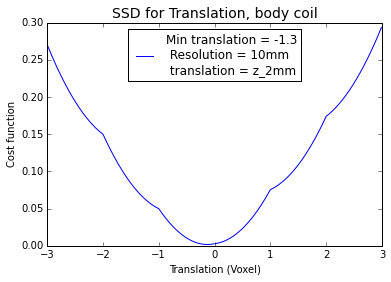

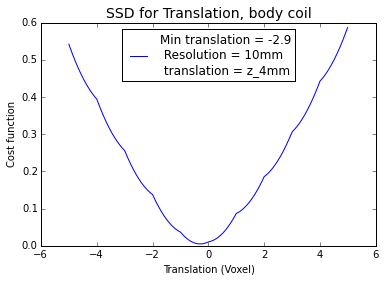

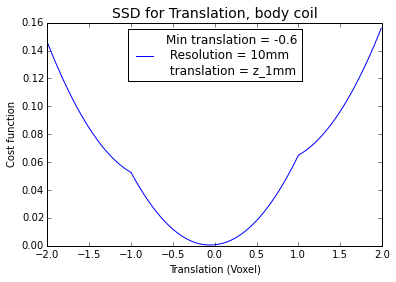

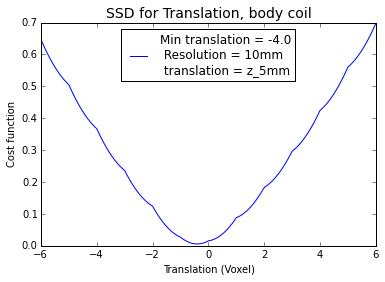

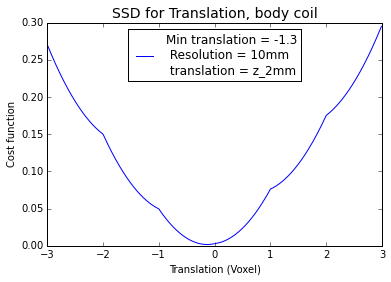

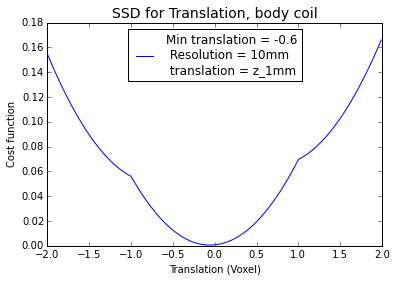

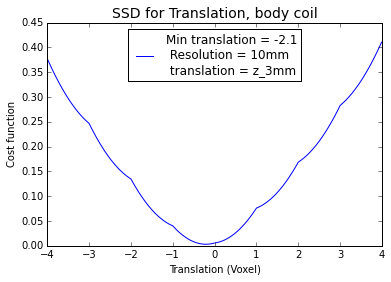

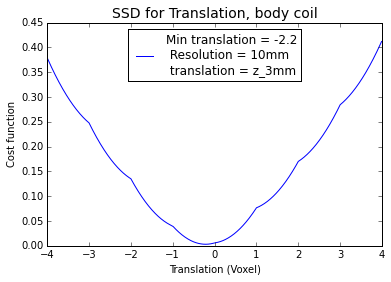

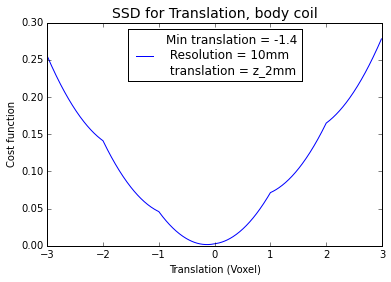

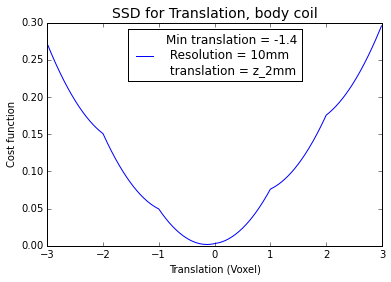

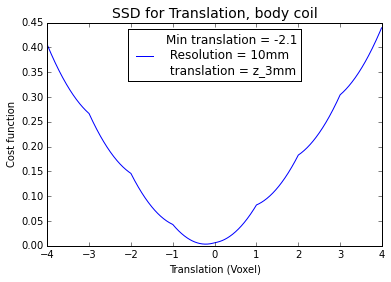

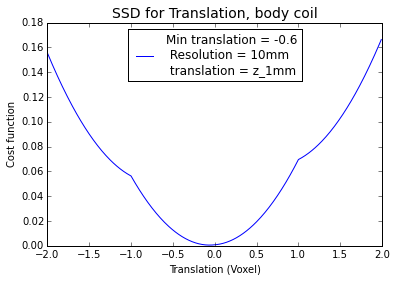

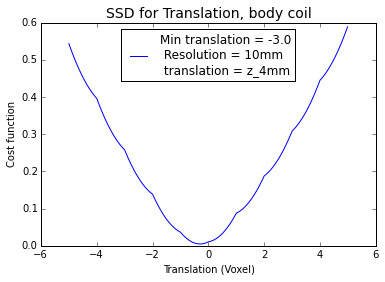

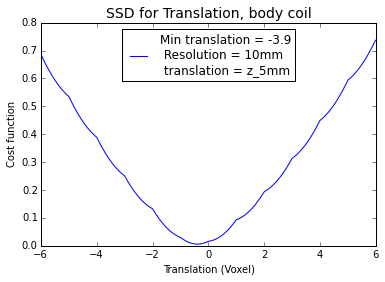

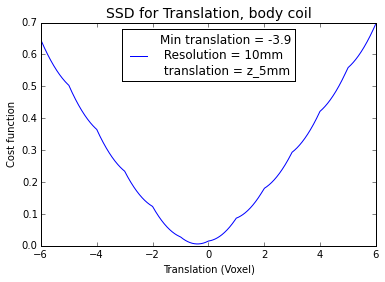

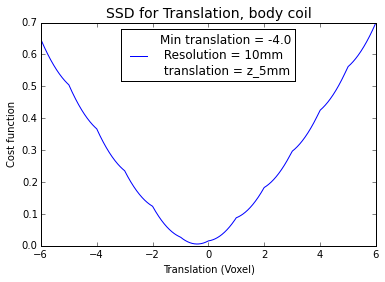

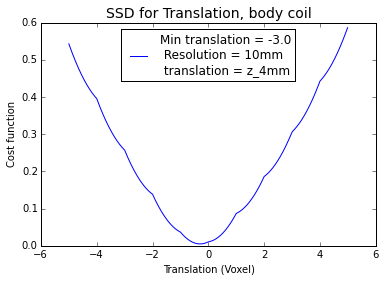

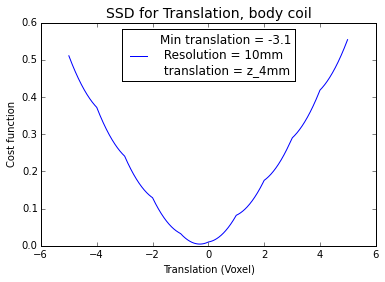

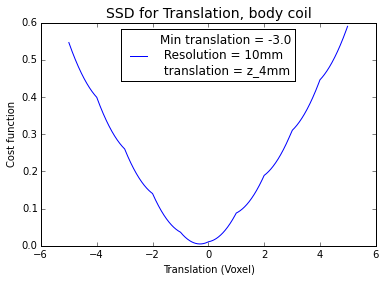

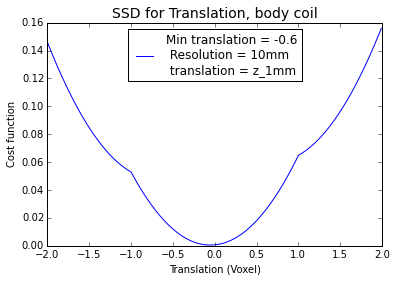

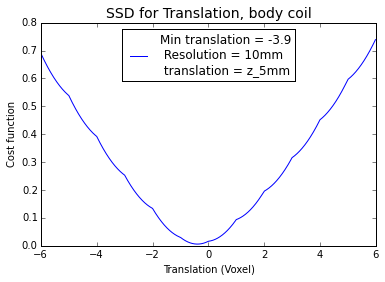

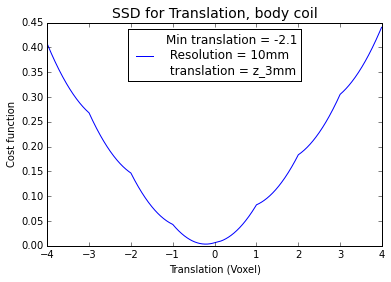

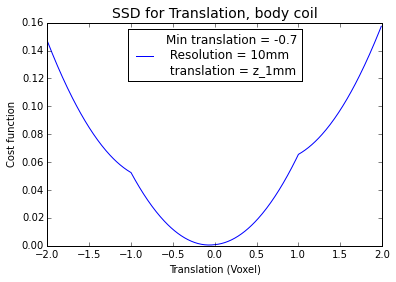

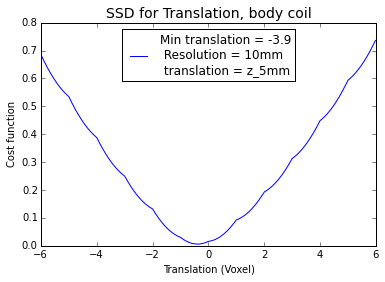

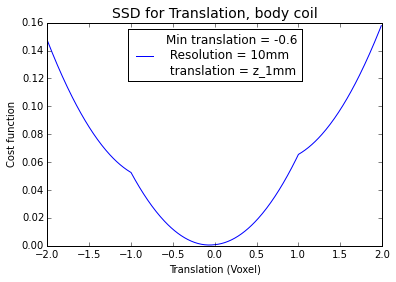

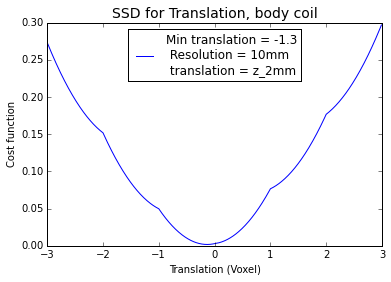

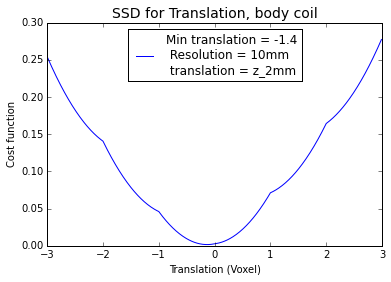

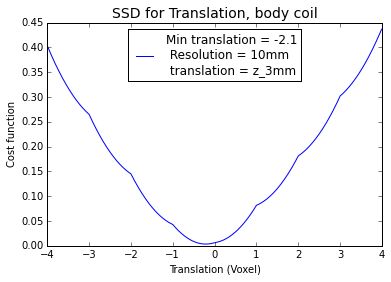

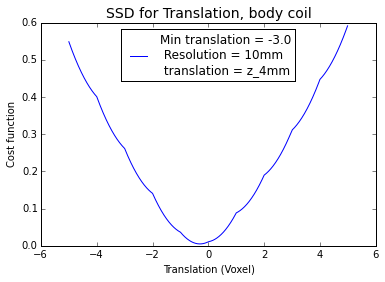

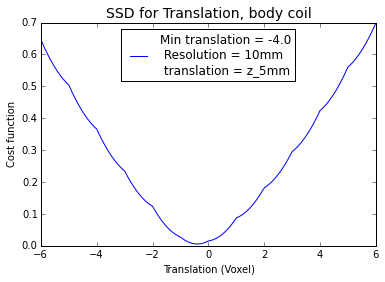

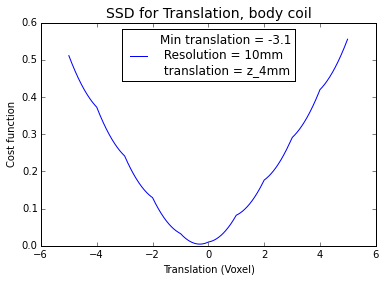

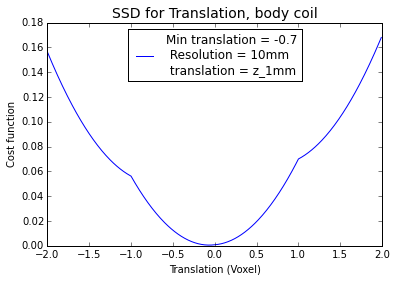

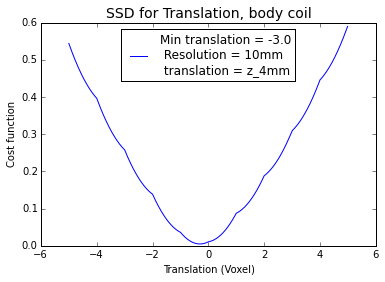

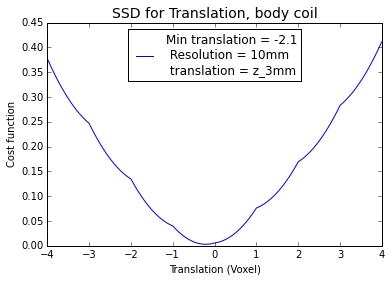

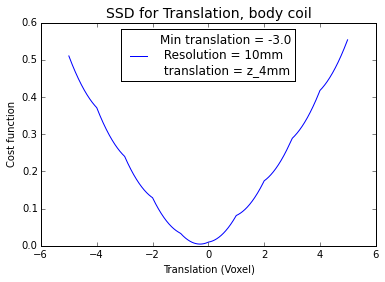

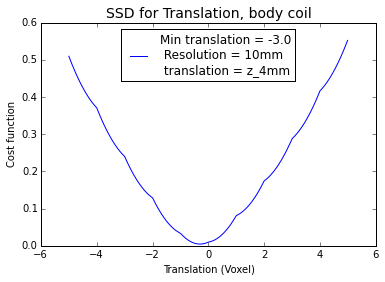

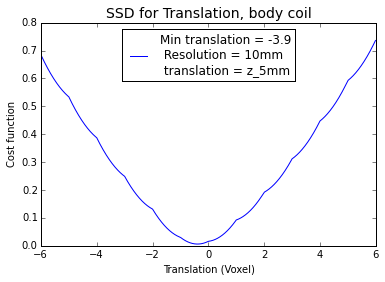

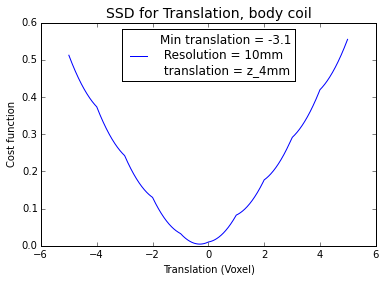

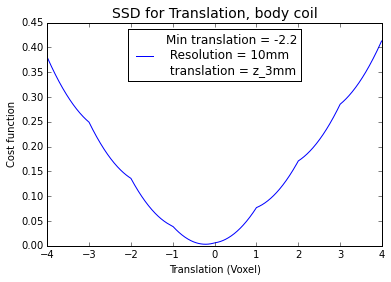

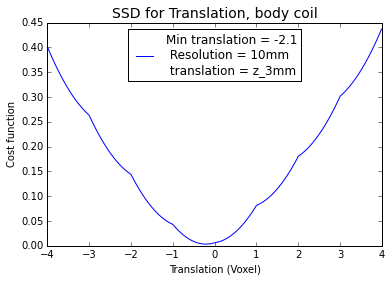

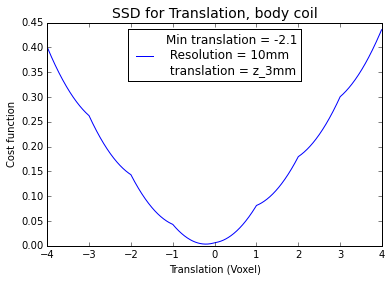

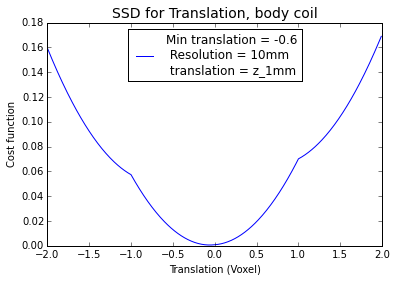

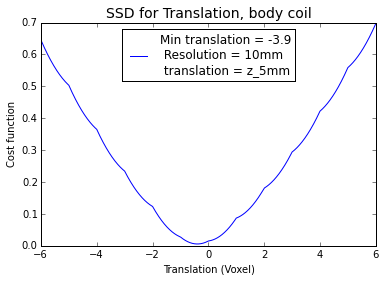

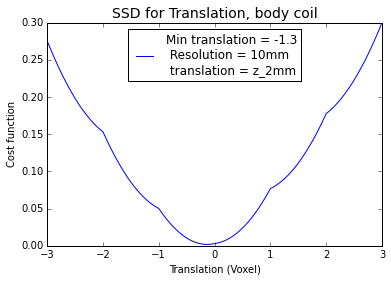

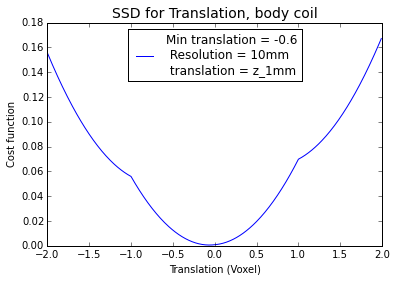

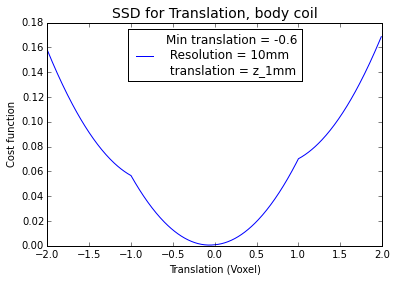

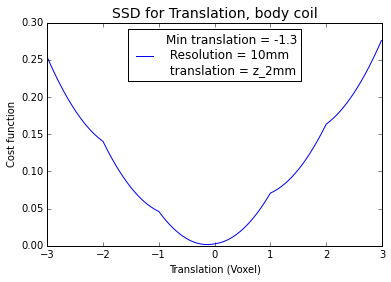

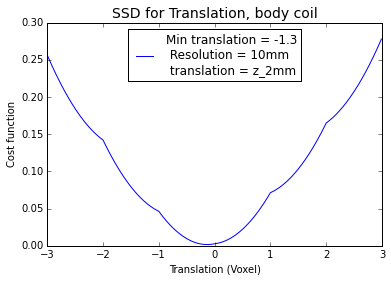

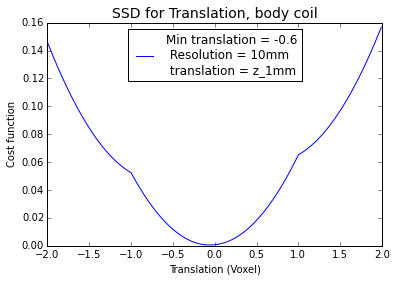

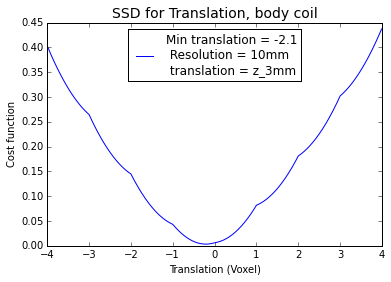

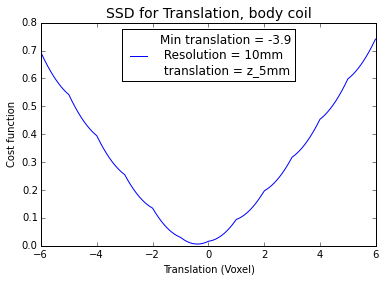

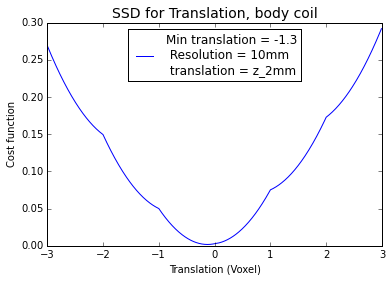

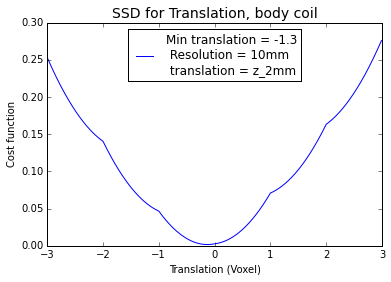

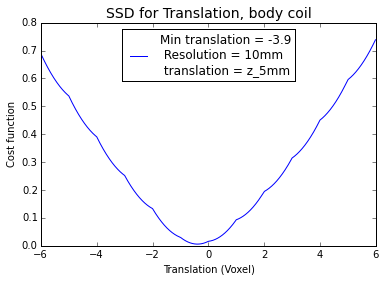

In [304]:
for k in cost_trans_linear_masked['x'].keys():
    step = k[1]
    trans = np.arange(-step-1,step+1,0.01)
    plot_cost_func_t(trans,cost_trans_linear_masked['x'][k],'10mm','z_%smm'%step,'body')
    plt.show()

In [427]:
# Linear Translation
cost_trans_linear = {}
for k in axes_dict:
    print k,
    cost_trans_linear[k] = translations('10',k)
pickle.dump(cost_trans_linear, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_10.p','wb'))

xz y yz xy x z


In [191]:
# Linear Translation
cost_trans_linear = {}
for k in axes_dict:
    print k,
    cost_trans_linear[k] = translations('8',k)
pickle.dump(cost_trans_linear, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_8.p','wb'))

xz y yz xy x z


In [192]:
# Linear Translation
cost_trans_linear = {}
for k in axes_dict:
    print k,
    cost_trans_linear[k] = translations('6_4',k)
pickle.dump(cost_trans_linear, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_linear_6_4.p','wb'))

xz y yz xy x z


In [193]:
# Cubic Translation
cost_trans_cubic = {}
for k in axes_dict:
    print k,
    cost_trans_cubic[k] = translations('10',k,order=3)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_cubic_10.p','wb'))

xz y yz xy x z


In [194]:
# Cubic Translation
cost_trans_cubic = {}
for k in axes_dict:
    print k,
    cost_trans_cubic[k] = translations('8', k, order = 3)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_cubic_8.p','wb'))

xz y yz xy x z


In [195]:
# Cubic Translation
cost_trans_cubic = {}
for k in axes_dict:
    print k,
    cost_trans_cubic[k] = translations('6_4', k, order = 3)
pickle.dump(cost_trans_cubic, open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/cost_trans_cubic_6_4.p','wb'))

xz y yz xy x z


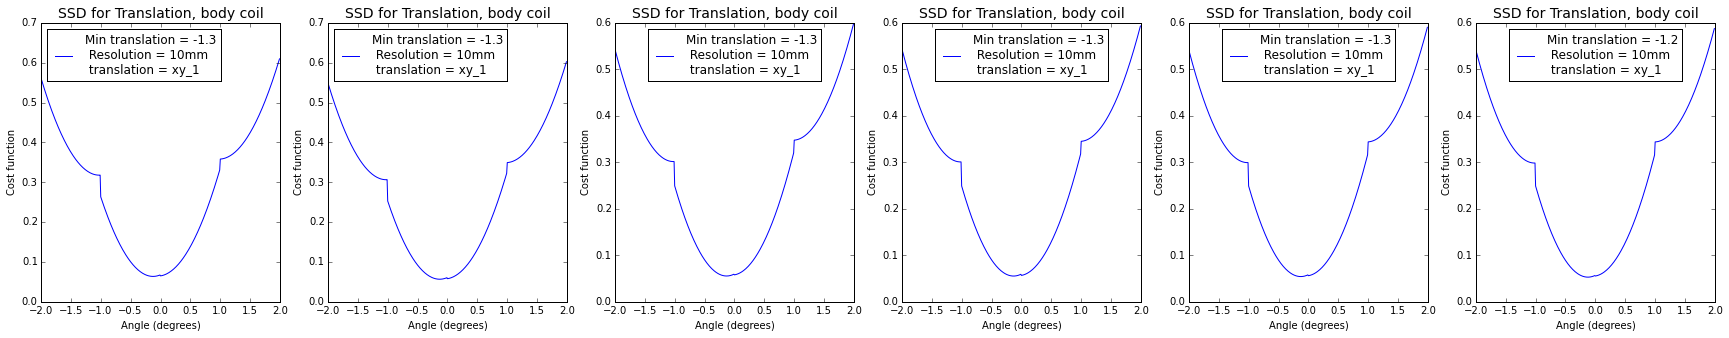

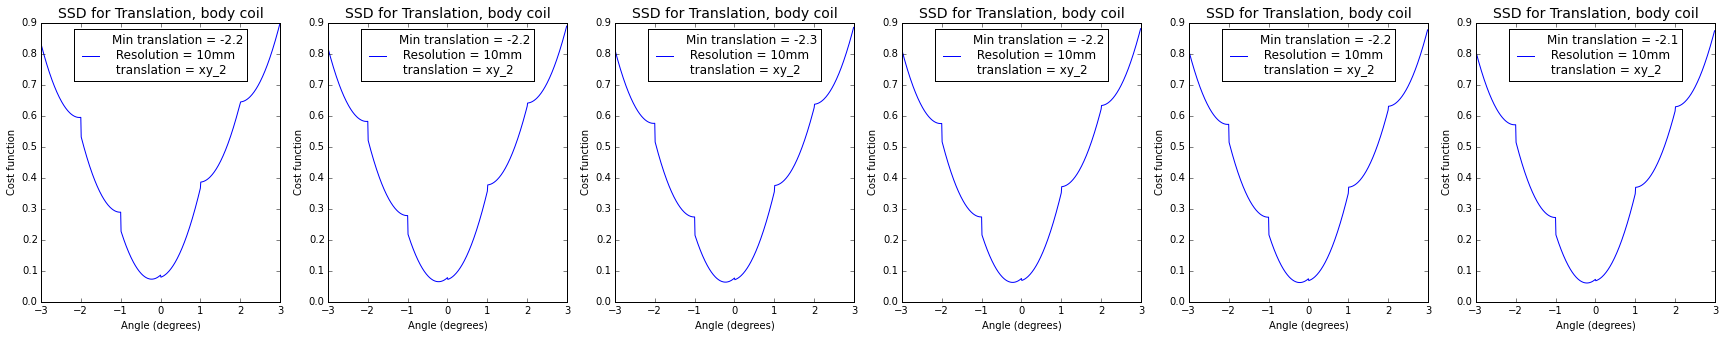

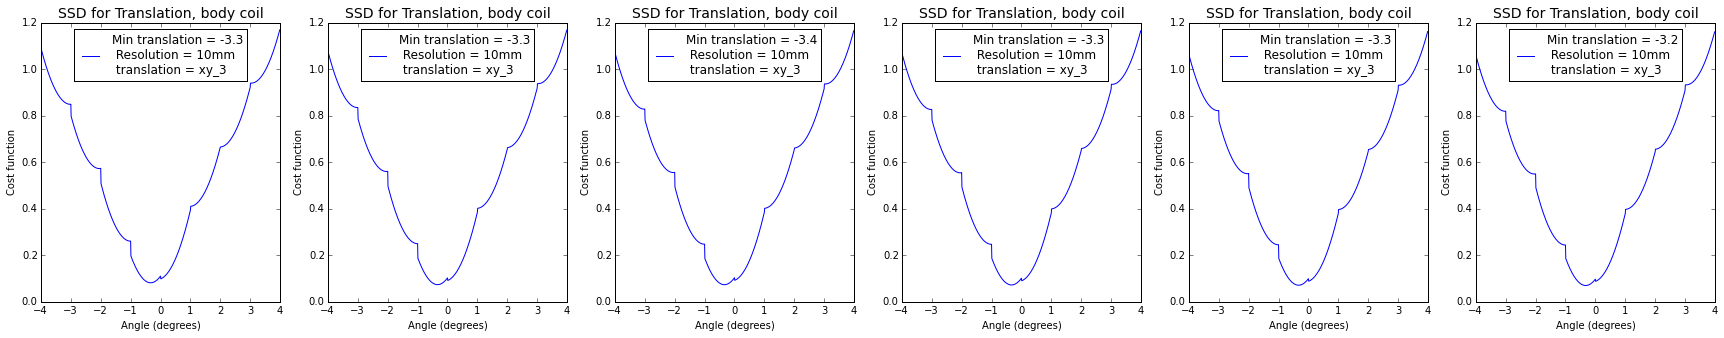

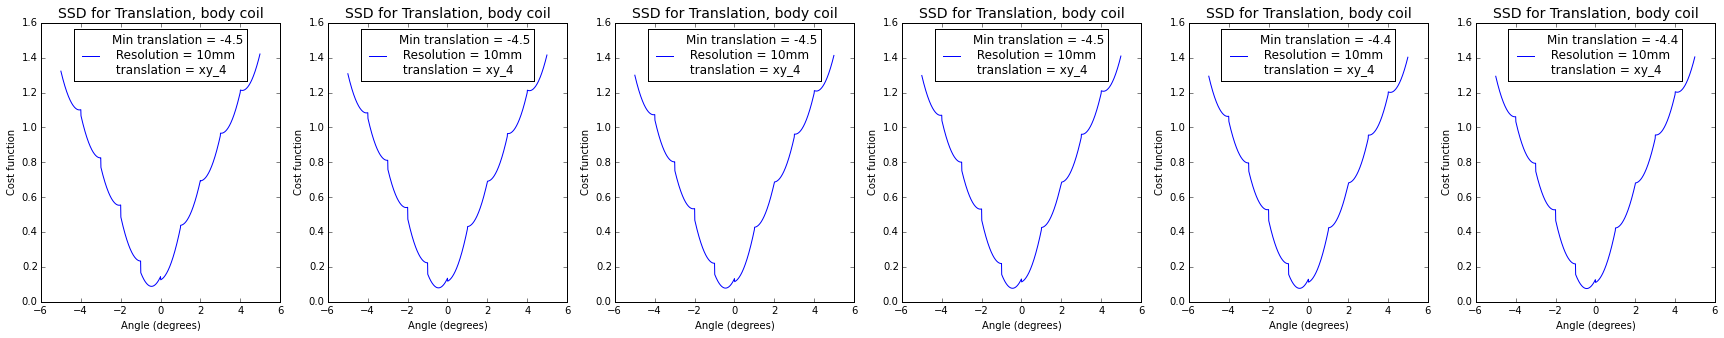

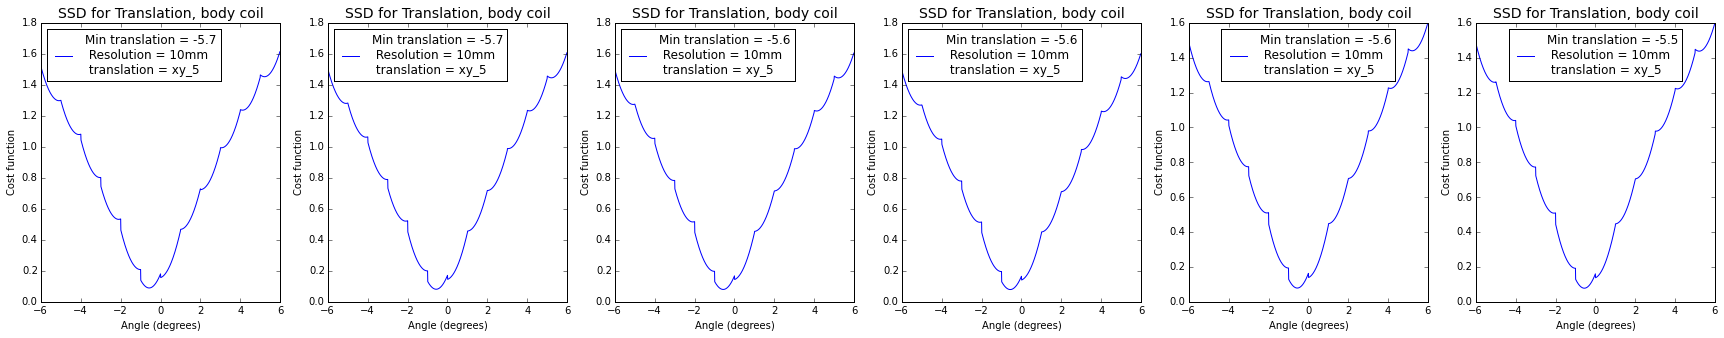

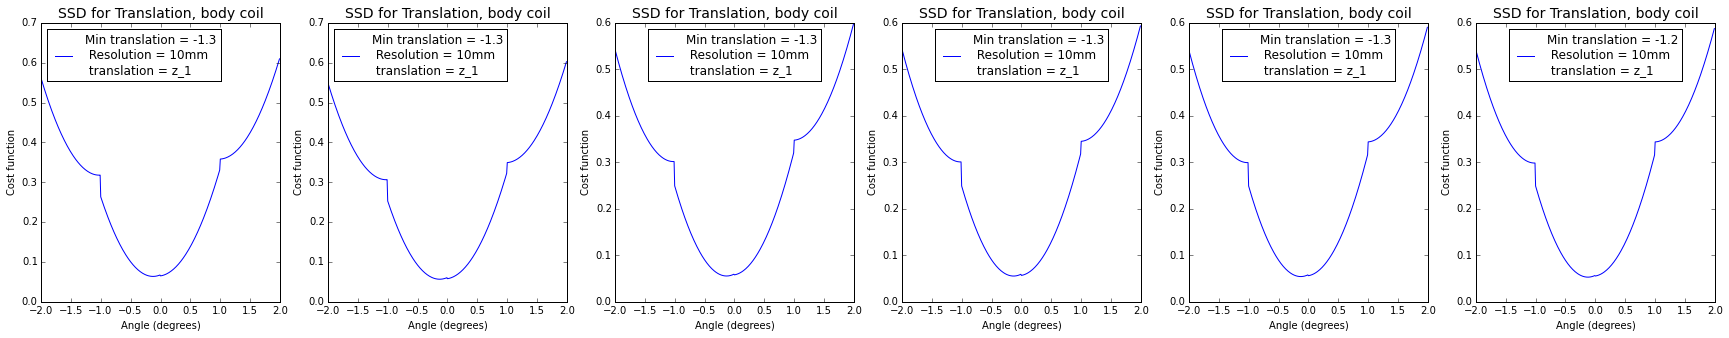

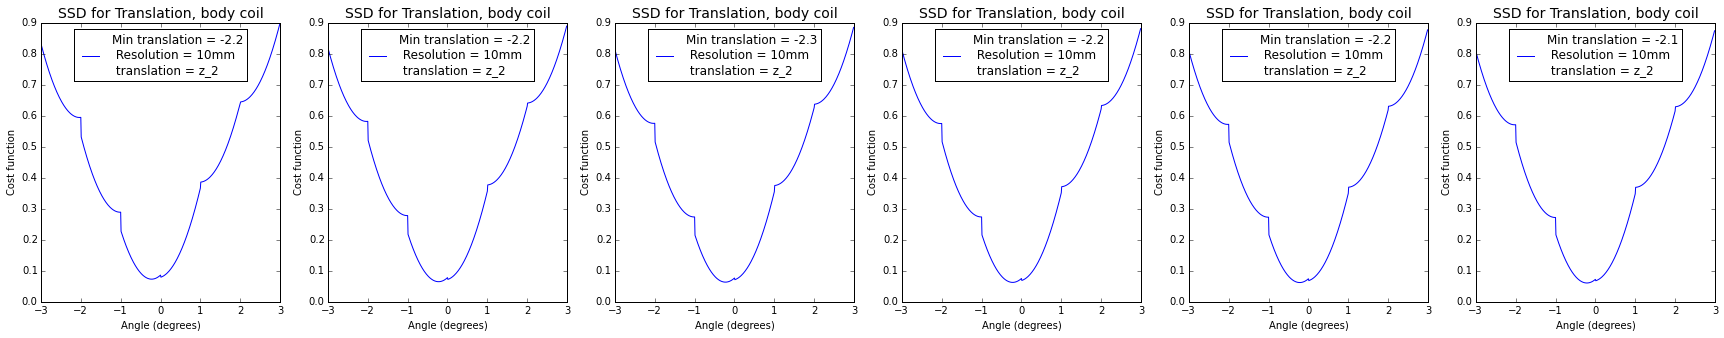

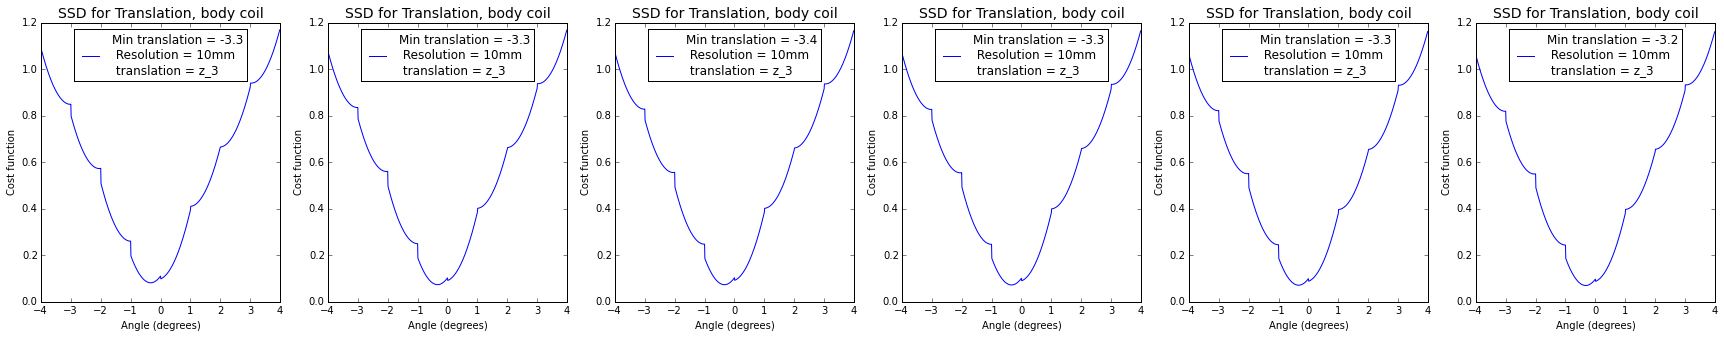

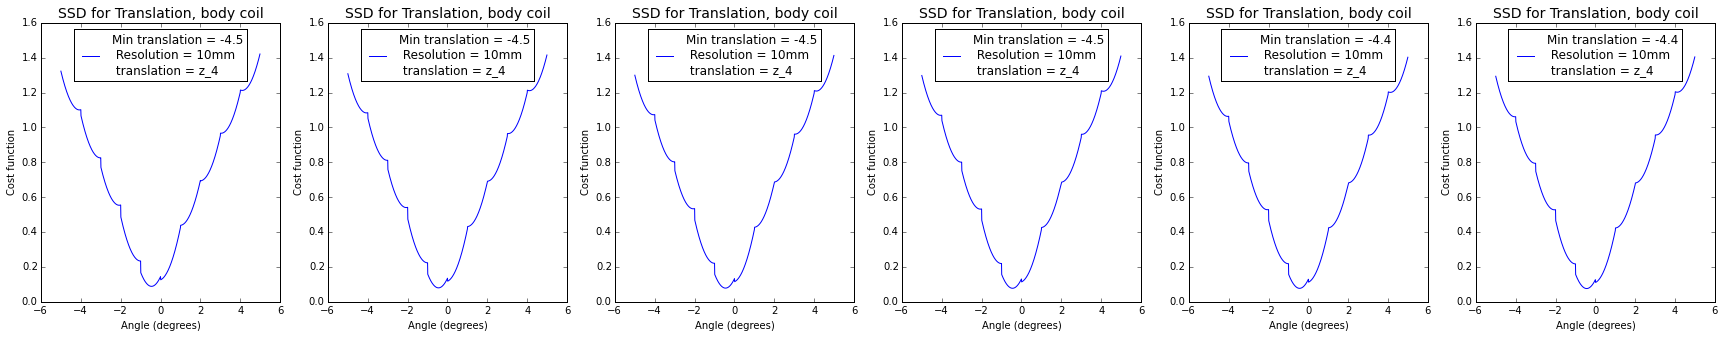

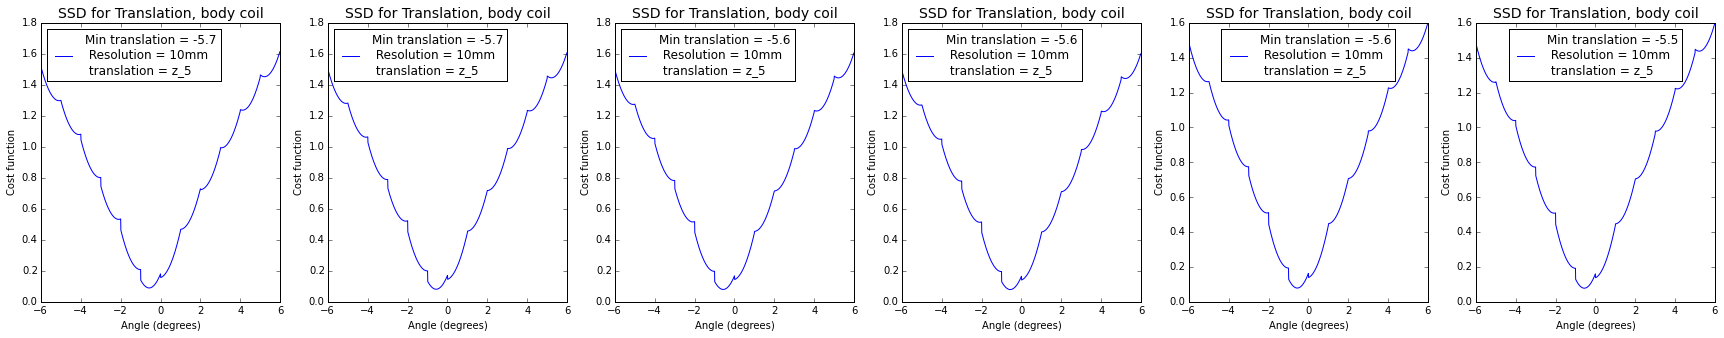

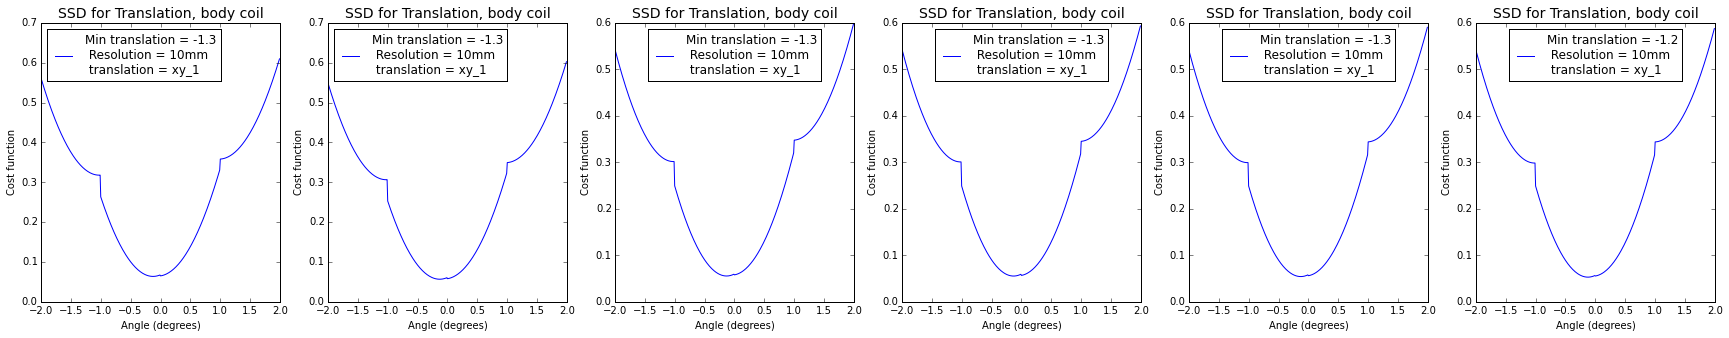

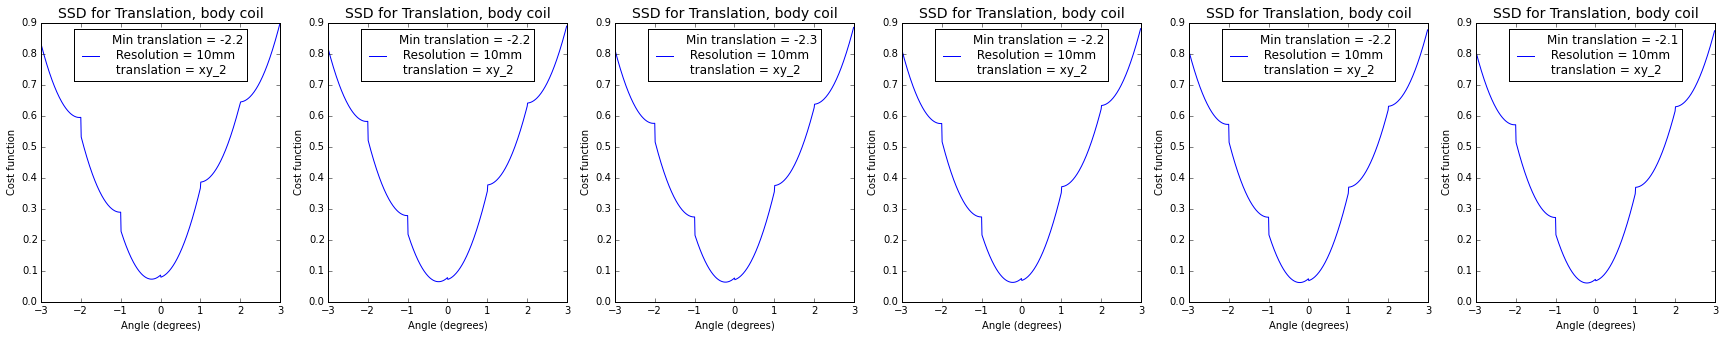

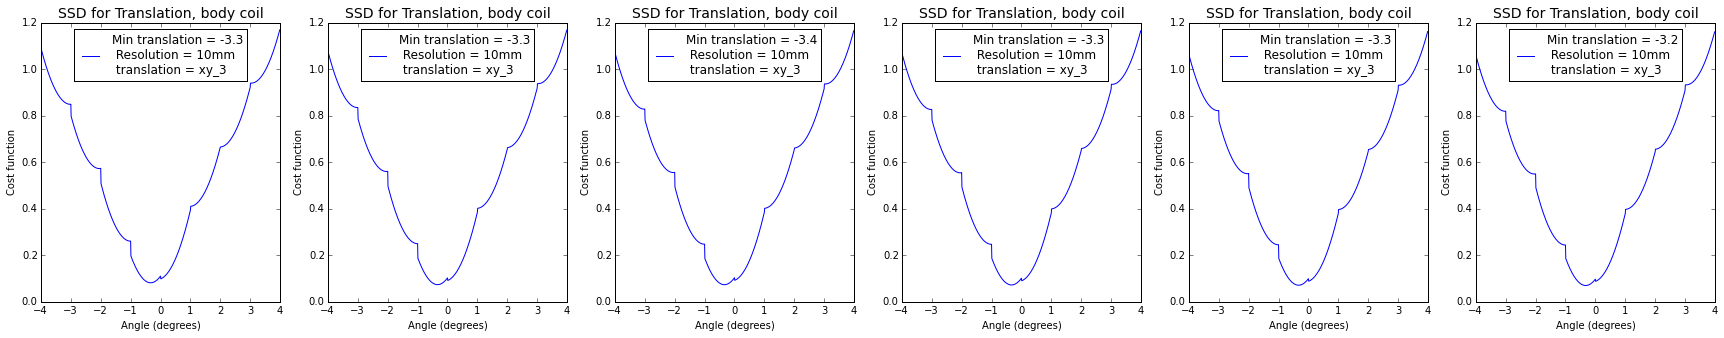

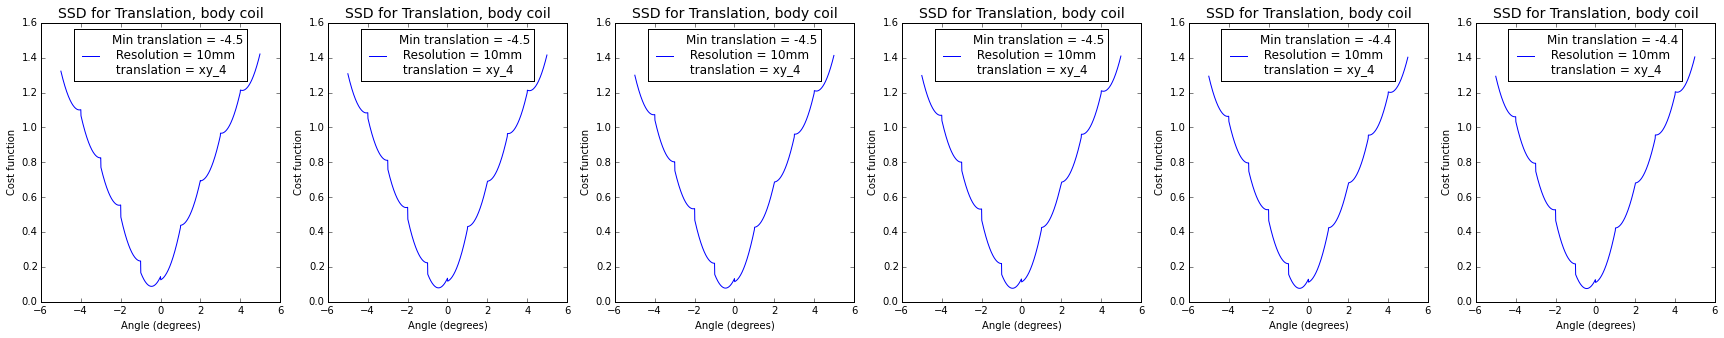

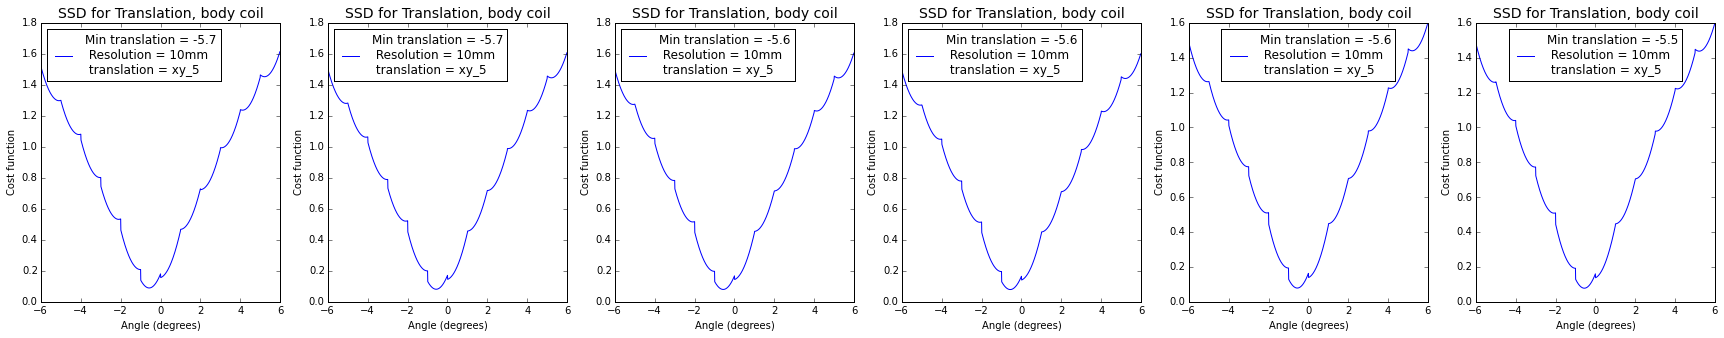

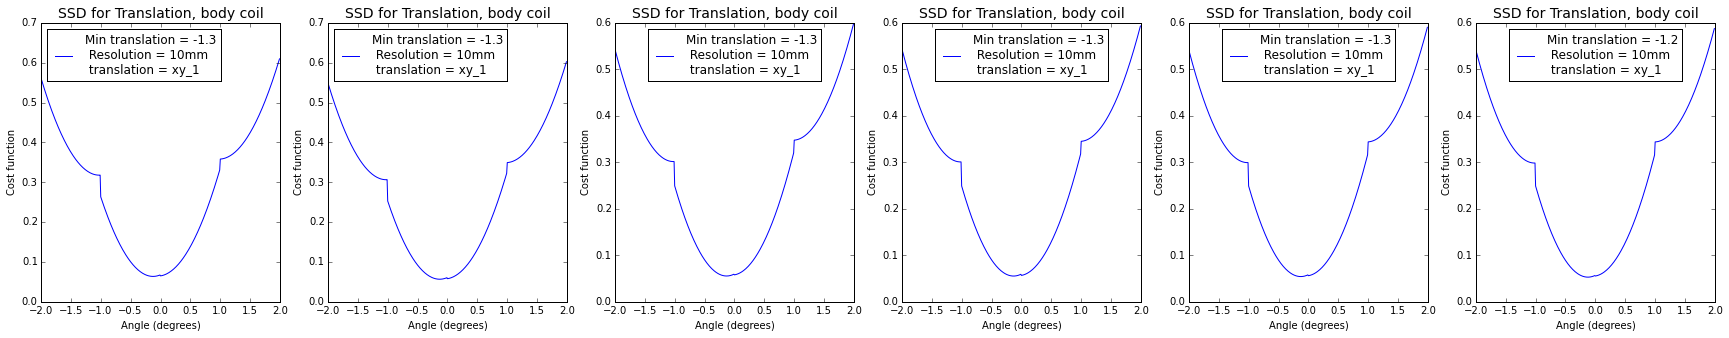

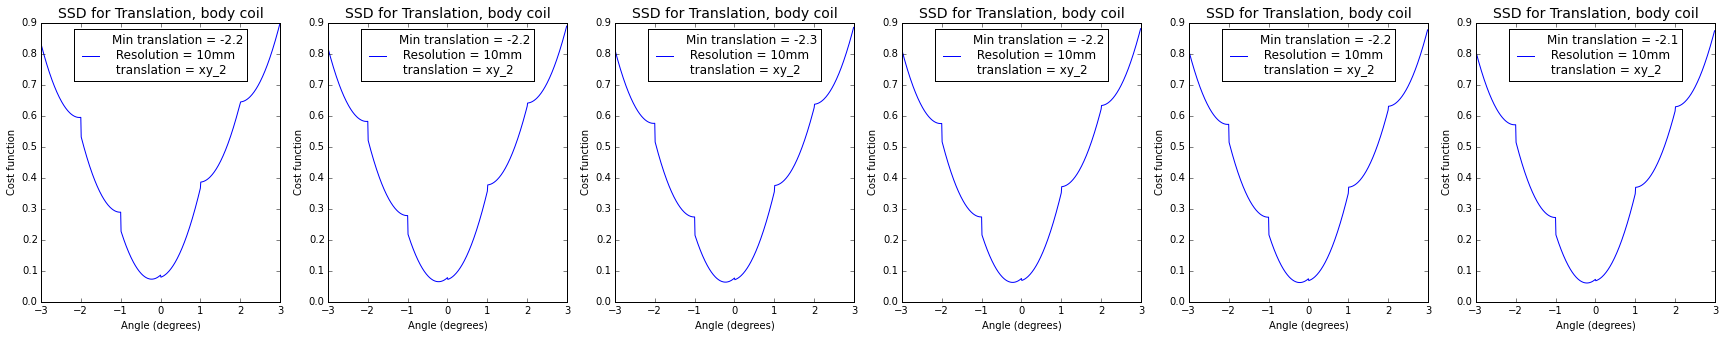

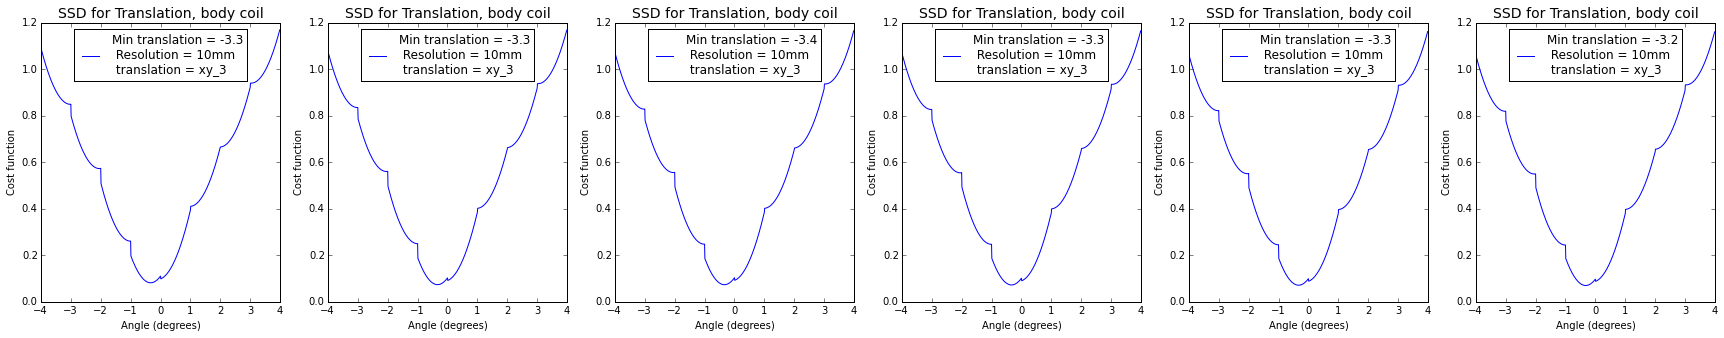

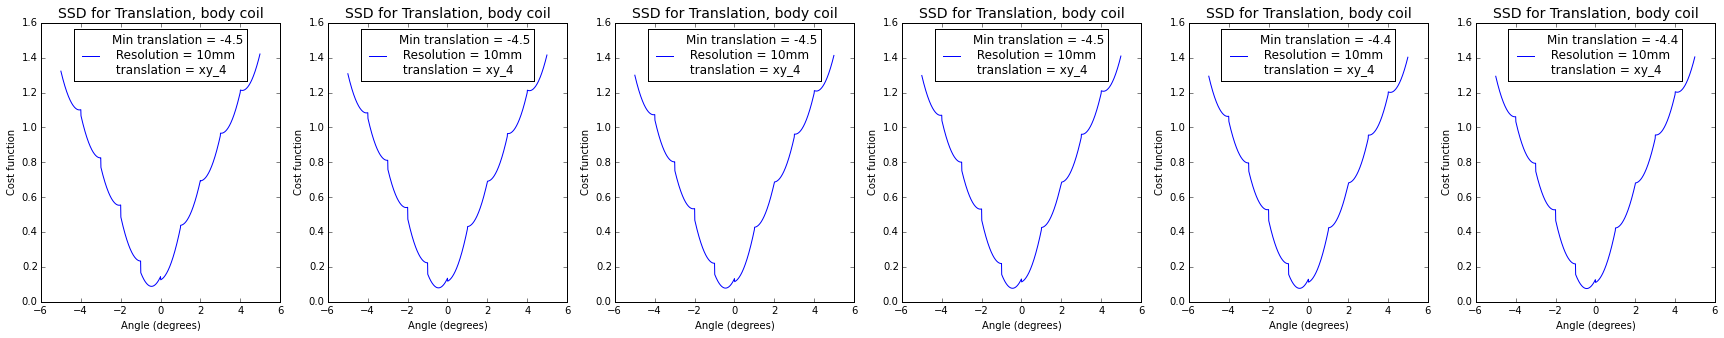

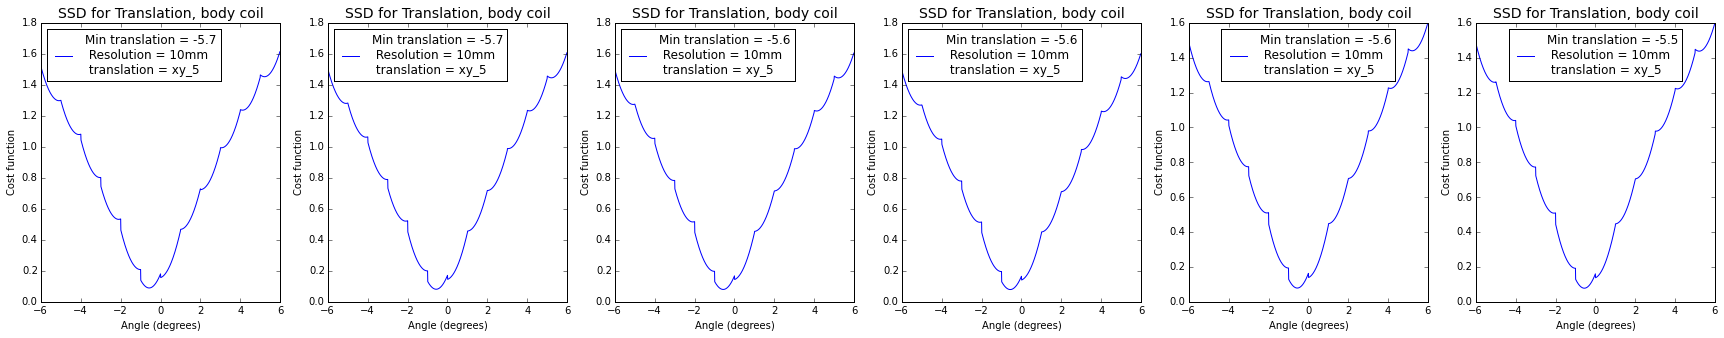

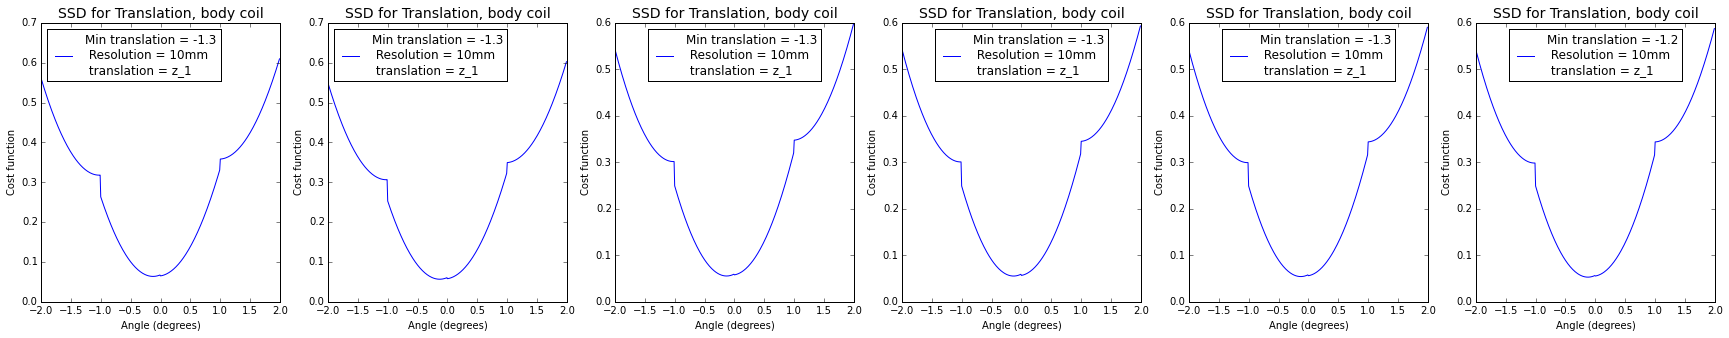

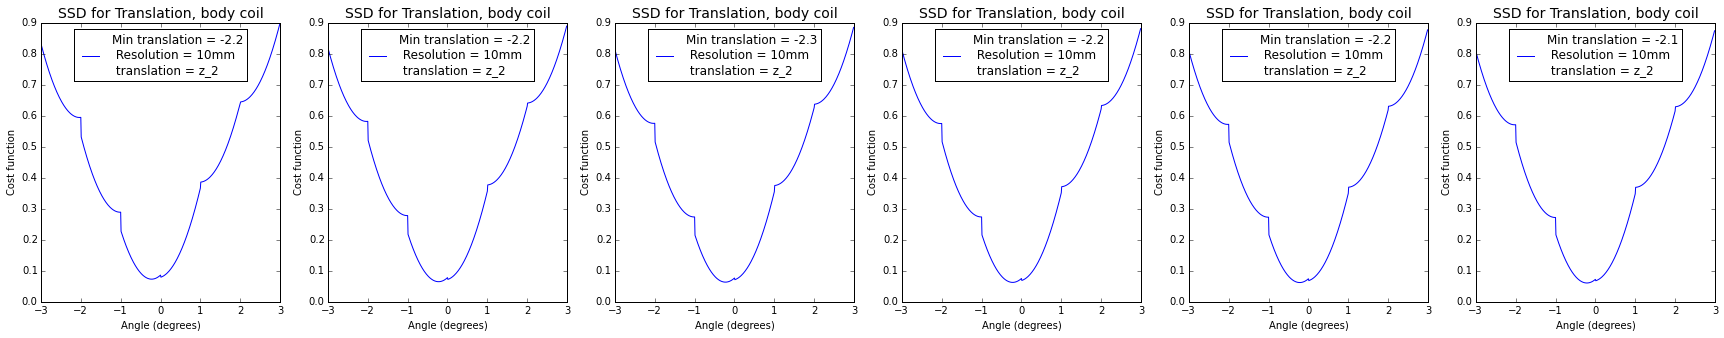

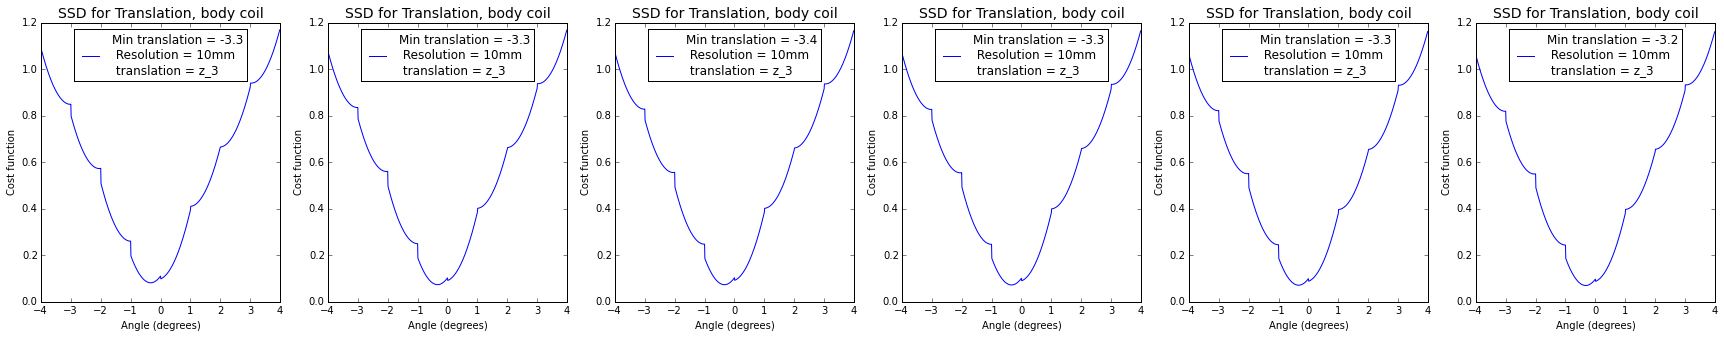

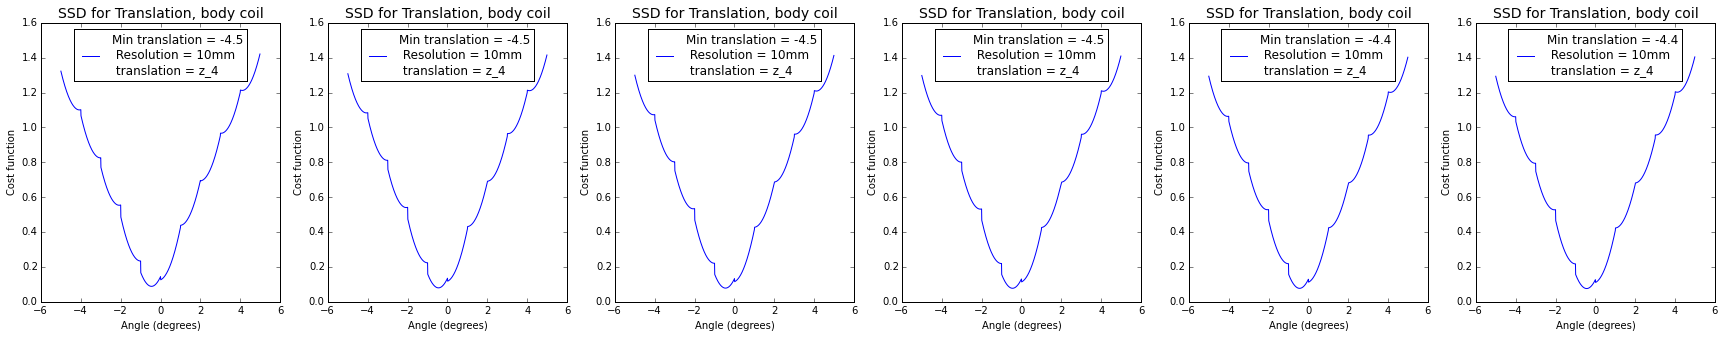

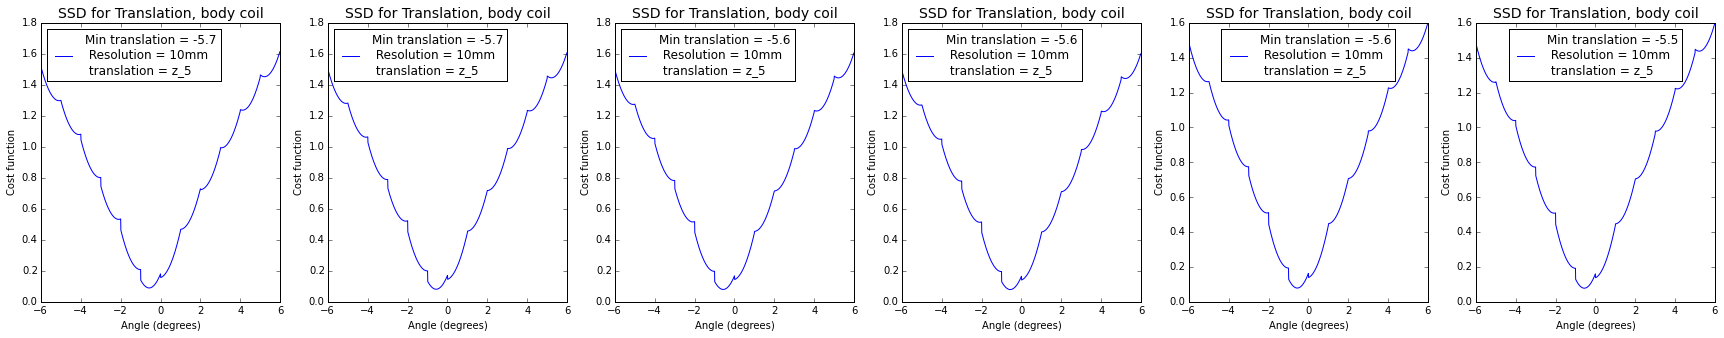

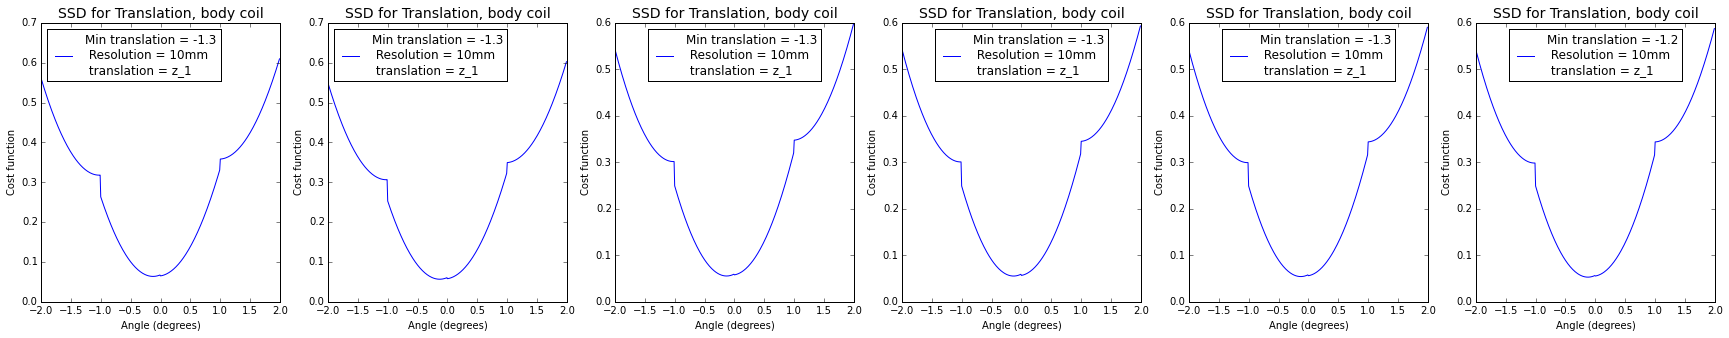

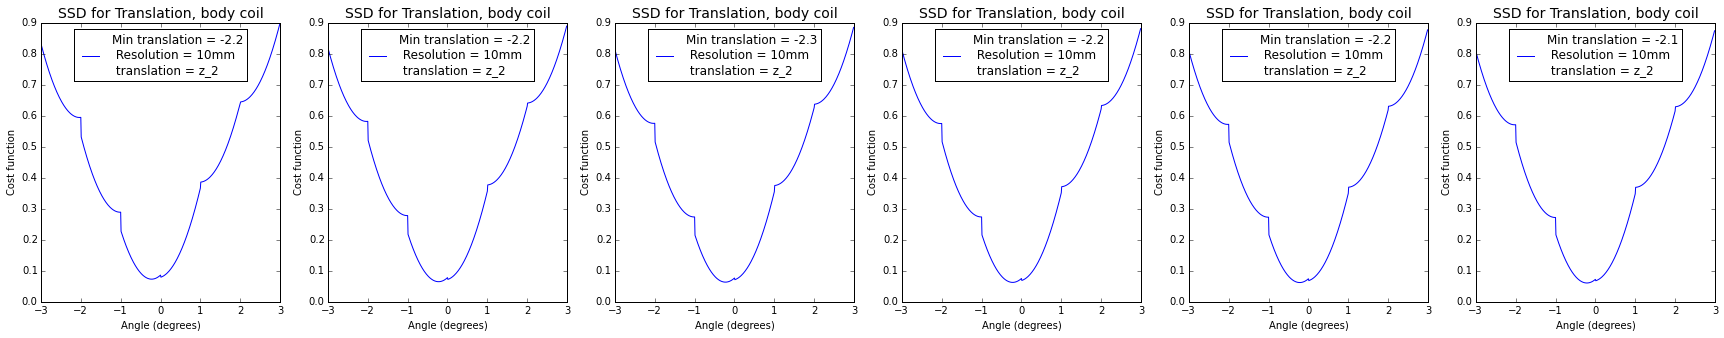

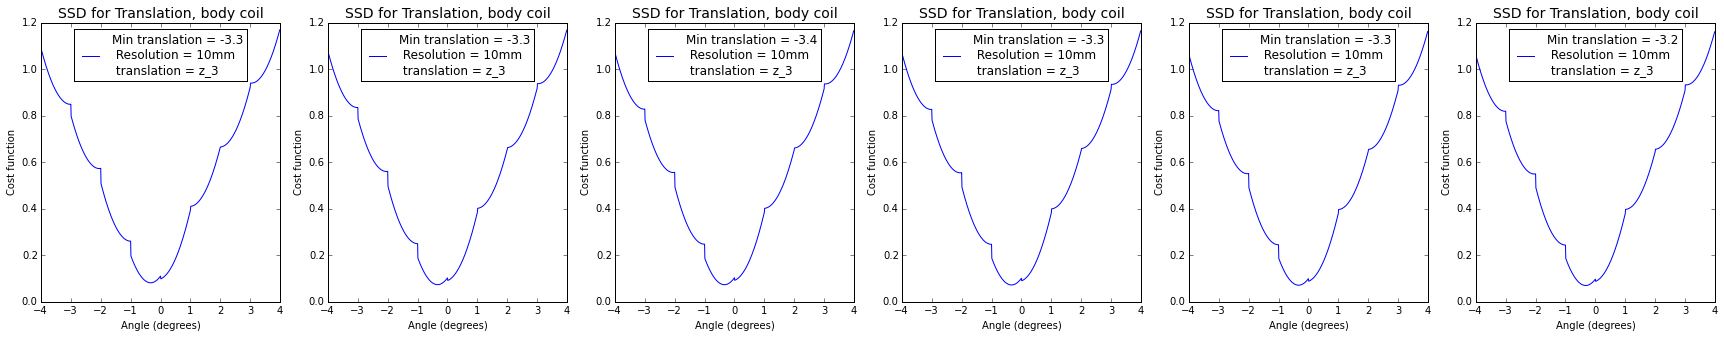

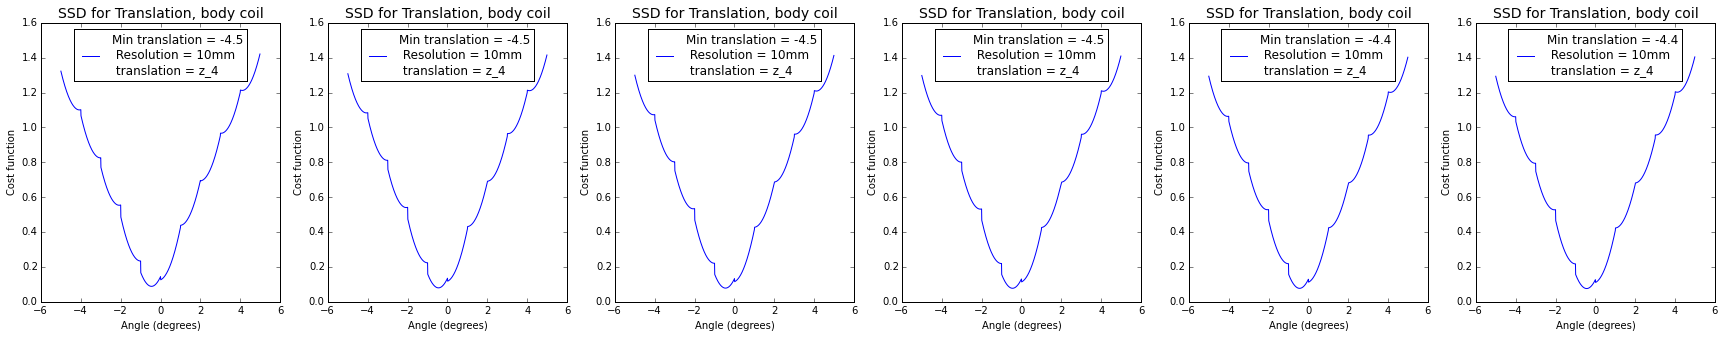

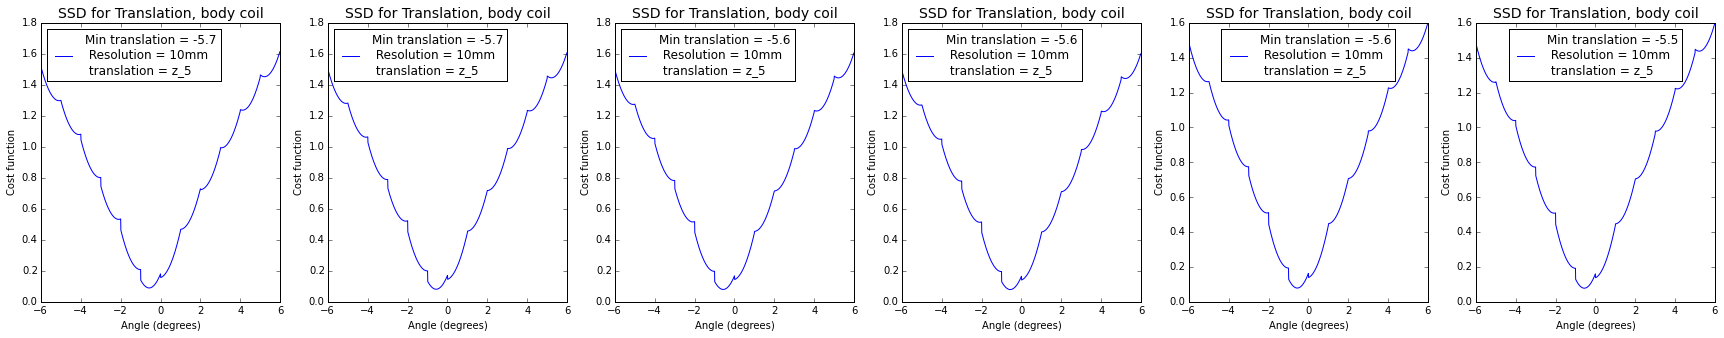

In [176]:
for k,v in axes_dict.iteritems():
    for loop in xrange(1,6):
        plt.figure(figsize = [30,5])
        for i in xrange(6):
            rep = i + loop * 6
            rot_angle = rep_to_angle(rep,rot_range)
            step = rot_angle[1]
            trans = np.arange(-step-1,step+1,0.01)
            #print v,step
            plt.subplot(1,6,i+1)
            plot_cost_func_t(trans,cost_t[rot_angle],'10mm', v+'_'+str(step))
        plt.show()

# Quarternions

In [34]:
def Hamilton_product(a1, b1, c1, d1, a2, b2, c2, d2):
    a = a1*a2-b1*b2-c1*c2-d1*d2
    i = a1*b2+b1*a2+c1*d2-d1*c2
    j = a1*c2-b1*d2+c1*a2+d1*b2
    k = a1*d2+b1*c2-c1*b2+d1*a2
    return a, i, j, k

In [35]:
from rotation_3d import trilinear_interp, tricubic_interp
def rotate_coords_quaternion(theta, ui, uj, uk, x, y, z):
    """
    Return the position of rotated point about quaternion u by theta degrees
    """
    ox = oy = oz = 15.5
    x, y, z = np.asarray(x) - ox, np.asarray(y) - oy, np.asarray(z) - oz
    
    # convert degrees to radians
    theta = to_radian(theta)
    qr = np.cos(theta/2.)
    s = np.sin(theta/2.)
    
    # coefficients for q and q^-1
    a1 = qr
    b1 = ui*s
    c1 = uj*s
    d1 = uk*s

    # calculate q*p*q^-1
    qp_a1, qp_b1, qp_c1, qp_d1 = Hamilton_product(a1,b1,c1,d1,0,x,y,z)
    
    # calculate final coordinates
    a, b, c, d = Hamilton_product(qp_a1, qp_b1, qp_c1, qp_d1,a1,-b1,-c1,-d1)
    
    return b + ox, c + oy, d + oz

def volrotate_quaternion(volume, theta, ui, uj, uk,interpolation = 'trilinear'):
    """
    Rotate a given volume by theta degrees about the unit quarternion u
    """
    # Make sure ui, uj, uk makes a unit quarternion
    if (ui**2 + uj**2 + uk**2 != 1):
        norm = np.sqrt(ui**2 + uj**2 + uk**2)
        ui = ui/norm
        uj = uj/norm
        uk = uk/norm
    
    shape = volume.shape
    # find center of the volume
    ox = shape[1]/2.-0.5
    oy = shape[0]/2.-0.5
    oz = shape[2]/2.-0.5
    
    if(shape[0] == 26): res = '10mm'
    elif(shape[0] == 32): res = '8mm'
    else: res = '6_4mm'
    xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
    
    dest_x, dest_y, dest_z = rotate_coords_quaternion(theta, ui, uj, uk, xx, yy, zz)
    if(interpolation == 'trilinear'):
        dest = trilinear_interp(volume, dest_x, dest_y, dest_z)
    if(interpolation == 'tricubic'):
        n = shape[0]
        dest = np.empty([n,n,n])
        for i in xrange(shape[0]):
            for j in xrange(shape[1]):
                for k in xrange(shape[2]):
                    dest[i,j,k] = tricubic_interp(volume,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k])
    return dest

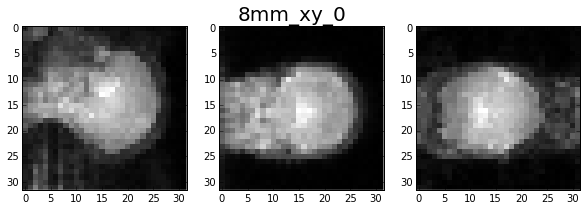

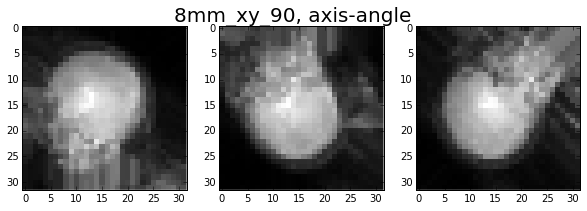

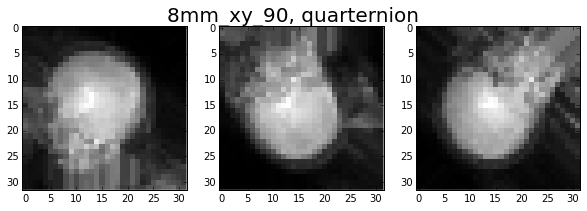

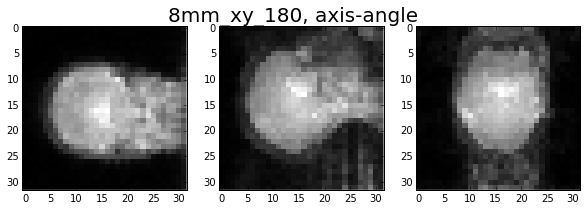

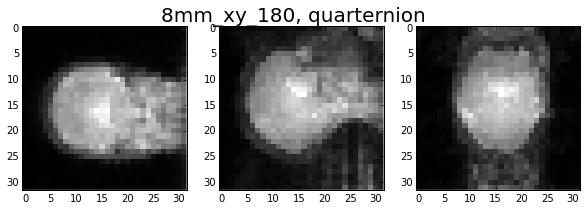

In [36]:
rot_ax = 'xy'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
plot_volume(testVol1,'8mm','xy_0')
plot_volume(volrotate(testVol1,90,1,1,0),'8mm','xy_90, axis-angle')
plot_volume(volrotate_quaternion(testVol1,90,1,1,0),'8mm','xy_90, quarternion')
plot_volume(volrotate(testVol1,180,1,1,0),'8mm','xy_180, axis-angle')
plot_volume(volrotate_quaternion(testVol1,180,1,1,0),'8mm','xy_180, quarternion')